In [ ]:
from LLMHandler import LLMHandler


# Text task

In [23]:
import os
import time
from huggingface_hub import InferenceClient
from langchain_core.runnables import Runnable
from IPython.display import Video, display

class VideoGenerator(Runnable):
    def __init__(self, model, api_key, filename_prefix="video", provider = "replicate"):
        self.client = InferenceClient(provider= provider, token=api_key)
        self.model = model
        self.filename_prefix = filename_prefix

    def _generate_filename(self):
        timestamp = int(time.time())
        return f"{self.filename_prefix}_{timestamp}.mp4"

    def invoke(self, prompt, config=None):
        """Generate video from raw prompt"""
        filename = self._generate_filename()
        video = self.client.text_to_video(prompt, model=self.model)
        with open(filename, "wb") as f:
            f.write(video)
        return filename

    def play(self, filepath):
        """Display video in notebook"""
        display(Video(filepath, embed=True))


In [29]:
# --- Usage ---
api_token = os.getenv("HF_TOKEN")

video_gen = VideoGenerator(
    model="genmo/mochi-1-preview",
    api_key=api_token,
    provider="fal-ai"
)

# Generate and save video
file_path = video_gen.invoke("A cinematic video of a spaceship landing on Mars at sunset")
print(f"Video saved as {file_path}")

# Play video in notebook
video_gen.play(file_path)

HfHubHTTPError: 402 Client Error: Payment Required for url: https://router.huggingface.co/fal-ai/fal-ai/mochi-v1?_subdomain=queue (Request ID: Root=1-68d0f1e8-7d0996754febf6356075e642;6448fdd4-d0b9-489b-a7b6-73484edcc565)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

In [ ]:
# Initialize handler (no tools needed for plain text)
handler = LLMHandler()

In [ ]:
IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"

In [ ]:
resp = handler.run("Generate a photorealistic image of a cuddly cat wearing a hat.",model_name="gemini-2.0-flash-preview-image-generation", task_type="image")
print(resp.content)


In [ ]:
import base64
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display, Markdown
from key_utils import get_next_key
import langchain_google_genai.chat_models as chat_mod

class LLMHandler:
    # --- Model names ---
    TEXT_MODEL = "gemini-2.0-flash"
    AUDIO_MODEL = "gemini-2.5-flash-preview-tts"
    IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"

    def __init__(self, system_message="You are a helpful assistant."):
        self.conversation_history = []
        self.system_message = system_message
        self._original_chat_with_retry = chat_mod._chat_with_retry  # save original for patching
        self.tools = tools or {}

    # --- Patch retry ---
    def _patch_retry(self, enable_retry: False):
        """Enable or disable internal retry inside LangChain/Google API"""
        if not enable_retry:
            def no_retry_chat_with_retry(**kwargs):
                generation_method = kwargs.pop("generation_method")
                metadata = kwargs.pop("metadata", None)
                return generation_method(
                    request=kwargs.get("request"),
                    retry=None,
                    timeout=None,
                    metadata=metadata
                )
            chat_mod._chat_with_retry = no_retry_chat_with_retry
        else:
            chat_mod._chat_with_retry = self._original_chat_with_retry

    # --- Helper: build messages ---
    # --- Build messages for LLM ---
    def _build_messages(self, user_input, task_type="text", system_override=None):
        messages = []
        if task_type in ["text", "tool"]:
            messages.append(SystemMessage(content=system_override if system_override else self.system_message))
        # Convert history
        for h in self.conversation_history:
            role = h.get("role")
            content = h.get("content")
            if role == "user":
                messages.append(HumanMessage(content=content))
            elif role == "assistant":
                messages.append(AIMessage(content=content))
        # Current input
        if task_type in ["text", "tool"]:
            messages.append(HumanMessage(content=user_input))
        else:
            messages = [HumanMessage(content=user_input)]
        return messages

    # --- Execute tools ---
    def _execute_tools(self, messages, response):
        """
        Executes any tool calls returned by the model.
        Updates messages with ToolMessage containing the result.
        """
        if tool_calls := getattr(response, "tool_calls", None):
            messages.append(response)
            for tool_call in tool_calls:
                tool_name = tool_call["name"]
                tool_args = tool_call["args"]

                # Find matching tool
                matched_tool = next((t for t in self.tools if t.name == tool_name), None)
                if matched_tool:
                    result = matched_tool.func(**tool_args)
                    print(f"[TOOL] Called {tool_name} with {tool_args}, returned: {result}")
                else:
                    result = f"No implementation for {tool_name}"
                    print(f"[TOOL] {result}")

                messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
            return True
        return False

 # --- Update history ---
    def _update_history(self, user_input, assistant_response, content_type="text"):
        self.conversation_history.append({"role": "user", "content": user_input, "type": "text"})
        # For images, store only the prompt, not actual image data
        if content_type == "image":
            self.conversation_history.append({"role": "assistant", "content": user_input, "type": "image"})
        else:
            self.conversation_history.append({"role": "assistant", "content": assistant_response, "type": content_type})


    # --- Helper: extract base64 image ---
    def _get_image_base64(self, response):
        for block in response.content:
            if isinstance(block, dict) and "image_url" in block:
                return block["image_url"]["url"].split(",")[-1]
        return None

    # --- TEXT GENERATION ---
    def generate_text(self, user_input, model_name=None, enable_retry=False):
        model_name = model_name or self.TEXT_MODEL
        self._patch_retry(enable_retry)
        messages = self._build_messages(user_input, task_type="text")
        for attempt in range(11):
            api_key, _ = get_next_key()
            print(f"➡️ Using API key: {api_key[:10]} of {_} (Attempt {attempt+1})")
            llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
            try:
                response = llm.invoke(messages)
                text = ""
                if isinstance(response.content, str):
                    text = response.content
                elif isinstance(response.content, list):
                    for block in response.content:
                        if isinstance(block, str):
                            text += block
                        elif isinstance(block, dict) and "text" in block:
                            text += block["text"]
                self._update_history(user_input, text)
                display(Markdown(text))
                return None
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                continue
        raise RuntimeError("All API keys failed or quota exceeded.")

    # --- STREAMING TEXT GENERATION ---
    def generate_text_stream(self, user_input, model_name=None, enable_retry=False):
        model_name = model_name or self.TEXT_MODEL
        self._patch_retry(enable_retry)
        messages = self._build_messages(user_input, task_type="text")
        for attempt in range(11):
            api_key, _ = get_next_key()
            print(f"➡️ Using API key: {api_key[:10]} of {_} (Attempt {attempt+1})")
            llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
            try:
                display_handle = display(Markdown(""), display_id=True)
                response_text = ""
                for chunk in llm.stream(messages):
                    if chunk.content:
                        response_text += chunk.content
                        display_handle.update(Markdown(response_text))
                self._update_history(user_input, response_text)
                return response_text
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                continue
        raise RuntimeError("All API keys failed or quota exceeded.")

    # --- AUDIO GENERATION ---
    def generate_audio(self, user_input, model_name=None, enable_retry=False):
        model_name = model_name or self.AUDIO_MODEL
        self._patch_retry(enable_retry)
        for attempt in range(11):
            api_key, _ = get_next_key()
            print(f"➡️ Using API key: {api_key[:10]} of {_} (Attempt {attempt+1})")
            llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
            messages = self._build_messages(user_input, task_type="audio")
            try:
                response = llm.invoke(messages, generation_config={"response_modalities": ["AUDIO"]})
                audio_bytes = response.additional_kwargs.get("audio")
                if audio_bytes:
                    audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
                    play(audio_segment)
                    self._update_history(user_input, "audio_played")
                    return "audio_played"
                else:
                    print("No audio returned")
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                continue
        raise RuntimeError("All API keys failed or quota exceeded.")

    # --- IMAGE GENERATION ---
    def generate_image(self, user_input, model_name=None):
        model_name = model_name or self.IMAGE_MODEL
        print(f"Generating image for: {user_input}")
        for attempt in range(5):
            api_key, _ = get_next_key()
            print(f"➡️ Using API key: {api_key[:10]} of {_} (Attempt {attempt+1})")
            llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
            # Pass **all previous image prompts** as history
            image_prompts = [h["content"] for h in self.conversation_history if h["type"] == "image"]
            # Include the current prompt
            all_prompts = "\n".join(image_prompts + [user_input])
            messages = [HumanMessage(content=all_prompts)]
            try:
                response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                image_base64 = self._get_image_base64(response)
                if image_base64:
                    display(Image(data=base64.b64decode(image_base64), width=400))
                    # Save only prompt for reference
                    self._update_history(user_input, image_base64, content_type="image")
                    return "image_generated"
                else:
                    print("No image returned")
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                continue
        raise RuntimeError("All API keys failed or quota exceeded.")

    # --- Generate text with tools ---
    # --- Generate text with tools (supports custom system message) ---
    # ... your existing code ...

    def generate_text_with_tools(self, user_input, tools, system_override=None):
        """
        Generate text using tools, using the exact same chat() logic.
        Tools are passed as a parameter.
        """
        print(f"\n[CHAT] User input: {user_input}")

        

        # Build conversation messages
        messages = [SystemMessage(content=system_override if system_override else self.system_message)]
        for h in self.conversation_history:
            role = HumanMessage if h["role"] == "user" else AIMessage
            messages.append(role(content=h["content"]))
        messages.append(HumanMessage(content=user_input))
        model_name = self.TEXT_MODEL
        for attempt in range(5):
            api_key, _ = get_next_key()
            print(f"➡️ Using API key: {api_key[:10]} of {_} (Attempt {attempt+1})")

            try:
                llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
                # Bind tools and force usage
                model_with_tools = llm.bind_tools(tools, tool_choice="any")
                response = model_with_tools.invoke(messages)
        
                # Handle tool calls
                if tool_calls := getattr(response, "tool_calls", None):
                    messages.append(response)  # append the response containing the tool call
                    for tool_call in tool_calls:
                        tool_name = tool_call["name"]
                        tool_args = tool_call["args"]
                        if tool_name in tools:
                            result = tools[tool_name](**tool_args)
                            print(f"[TOOL] Called {tool_name} with {tool_args}, returned: {result}")
                        else:
                            result = f"No implementation for {tool_name}"
                            print(f"[TOOL] {result}")
                        messages.append(ToolMessage(
                            content=str(result),
                            tool_call_id=tool_call['id']
                        ))
                    # Call model again with tool outputs
                    response = llm.invoke(messages)
                    print(f"[CHAT] Response is: {response.content}")
        
                # Save response in history
                text = response.content if isinstance(response.content, str) else str(response.content)
                self.conversation_history.append({"role": "user", "content": user_input})
                self.conversation_history.append({"role": "assistant", "content": text})
        
                return text
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                continue
        raise RuntimeError("All API keys failed or quota exceeded.")



    def chat(self, user_input, tools, system_override=None):
        print(f"\n[CHAT] User input: {user_input}")
        history = self.conversation_history  # Use actual conversation history
        
        # Ensure system message is always a valid string
        system_msg = system_override if system_override else "You are a helpful assistant."
        messages = [SystemMessage(content=system_msg)]  # <-- corrected line
        
        # Append previous conversation
        for h in history:
            role = HumanMessage if h["role"] == "user" else AIMessage
            messages.append(role(content=h["content"]))
        
        # Append current user input
        messages.append(HumanMessage(content=user_input))
        
        # Prepare model
        model_name = self.TEXT_MODEL
        api_key, _ = get_next_key()
        llm = ChatGoogleGenerativeAI(model=model_name, api_key=api_key)
        
        # Bind tools
        model_with_tools = llm.bind_tools(tools, tool_choice="any")
        response = model_with_tools.invoke(messages)
        
        # Execute tool calls if any
        if tool_calls := getattr(response, "tool_calls", None):
            messages.append(response)
            for tool_call in tool_calls:
        
                tool_name = tool_call["name"]
                tool_args = tool_call["args"]
    
                if callable(tool := next((t for t in tools if t.__name__ == tool_name), None)):
                    result = tool(**tool_args)
                    print(f"[TOOL] Called {tool_name} with {tool_args}, returned: {result}")
                else:
                    result = f"No implementation for {tool_name}"
                    print(f"[TOOL] {result}")

                messages.append(ToolMessage(
                    content=str(result),
                    tool_call_id=tool_call["id"]
                ))
            # Call model again with tool outputs
            response = llm.invoke(messages)
        
        # Update conversation history
        self.conversation_history.append({"role": "user", "content": user_input})
        self.conversation_history.append({"role": "assistant", "content": response.content})
        
        print(f"[CHAT] Response is: {response.content}")
        return response.content


            
            

In [3]:
from LLMHandler import LLMHandler
handler = LLMHandler()
# ----------------------------
# 6️⃣ TEXT WITH TOOLS
# ----------------------------
print("=== TEXT WITH TOOLS ===")
# Define tools as list
def get_ticket_price(destination_city):
    prices = {"Paris": "$120", "Berlin": "$150"}
    return prices.get(destination_city, "Price unknown")

tools = [get_ticket_price]

response = handler.generate_text_with_tools(
    user_input="How much is a ticket to Paris?",
    tools=tools,
    system_override="You are a travel assistant."
)
print("Tool response:", response)

# Call again with new input (history is preserved)
response2 = handler.generate_text_with_tools(
    user_input="And to Berlin?",
    tools=tools
)
print("Tool response:", response2)

=== TEXT WITH TOOLS ===

[CHAT] User input: How much is a ticket to Paris?
➡️ Using API key: AIzaSyA6Jo of sijan.paudel10 (Attempt 1)
[TOOL] Called get_ticket_price with {'destination_city': 'Paris'}, returned: $120
[CHAT] Response is: A ticket to Paris costs $120.
Tool response: A ticket to Paris costs $120.

[CHAT] User input: And to Berlin?
➡️ Using API key: AIzaSyD_ak of paudelsijan15 (Attempt 1)
[TOOL] Called get_ticket_price with {'destination_city': 'Berlin'}, returned: $150
[CHAT] Response is: A ticket to Berlin costs $150.
Tool response: A ticket to Berlin costs $150.


In [ ]:
# ----------------------------
# 1️⃣ Initialize Handler
# ----------------------------
handler = LLMHandler(system_message="You are a helpful assistant.")

# ----------------------------
# 2️⃣ TEXT GENERATION (normal)
# ----------------------------
print("=== TEXT GENERATION ===")
handler.generate_text("Explain blockchain in simple terms.")
handler.generate_text("Explain it in 2 lines.")


# ----------------------------
# 3️⃣ STREAMING TEXT
# ----------------------------
print("=== STREAMING TEXT ===")
handler.generate_text_stream("Explain async/await in JS in simple words.")


# ----------------------------
# 4️⃣ AUDIO GENERATION
# ----------------------------
print("=== AUDIO GENERATION ===")
handler.generate_audio("Read the following text aloud: Blockchain is a decentralized ledger.")

# ----------------------------
# 5️⃣ IMAGE GENERATION
# ----------------------------
print("=== IMAGE GENERATION ===")
# Example: single image
handler.generate_image("Draw a cute cat wearing a hat.")

# Example: chained history (change previous image)
handler.generate_image("Make the cat black and blue.")  # references previous image in history




In [236]:
from langchain.tools import tool

In [237]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}



def get_ticket_price(destination_city):
    """
    Python function that returns the price of a ticket to a given city.
    Get the price of a return ticket to the destination city.Call this whenever you need to know the ticket price, for example " "when a customer asks 'How much is a ticket to this city'
    Args:
        destination_city (str): Name of the city
    Returns:
        str: Ticket price or 'Unknown' if the city is not listed
    """
    print(f"[TOOL] get_ticket_price called with destination_city='{destination_city}'")
    city = destination_city.lower()  # Normalize input for dictionary lookup
    price = ticket_prices.get(city, "Unknown")
    print(f"[TOOL] Returning price: {price}")
    return price


In [238]:
get_ticket_price("Berlin")

[TOOL] get_ticket_price called with destination_city='Berlin'
[TOOL] Returning price: $499


'$499'

In [239]:
handler = LLMHandler()

response = handler.chat(
    user_input="How much is a ticket to Paris?",
    tools=tools,
    system_override="You are a travel assistant."
)

print(response)

print(handler.chat(user_input="and to berlin", tools=tools)) 


[CHAT] User input: How much is a ticket to Paris?
[TOOL] get_ticket_price called with destination_city='Paris'
[TOOL] Returning price: $899
[TOOL] Called get_ticket_price for 'Paris', returned: $899
[CHAT] Response is: A ticket to Paris costs $899.
A ticket to Paris costs $899.

[CHAT] User input: and to berlin
[TOOL] get_ticket_price called with destination_city='Berlin'
[TOOL] Returning price: $499
[TOOL] Called get_ticket_price for 'Berlin', returned: $499
[CHAT] Response is: A ticket to Berlin costs $499.
A ticket to Berlin costs $499.


In [172]:
handler = LLMHandler(tools=)

response = handler.generate_text_with_tools(
    user_input="How much is a ticket to Paris?",
    system_override="You are a travel assistant. Always provide accurate travel info."
)
print(response)


SyntaxError: invalid syntax (2012073489.py, line 1)

In [31]:
handler = UnifiedLLMHandler()
handler.run_audio("Say 'Hello, how are you?' in a friendly tone")


AttributeError: 'UnifiedLLMHandler' object has no attribute 'run_audio'

In [104]:
# Initialize the handler
handler = LLMHandler()

In [ ]:
handler.generate_text("Hello, how are you?")
handler.generate_text("Hello, What is Communication?")

handler.generate_text("Can you summarize that in two sentences?")
handler.generate_image("Draw a rocket flying in space.")
handler.generate_image("Change it color to blue.")
handler.generate_audio("Read the summary aloud.")



Generating image for: Draw a image of cat wearing hat


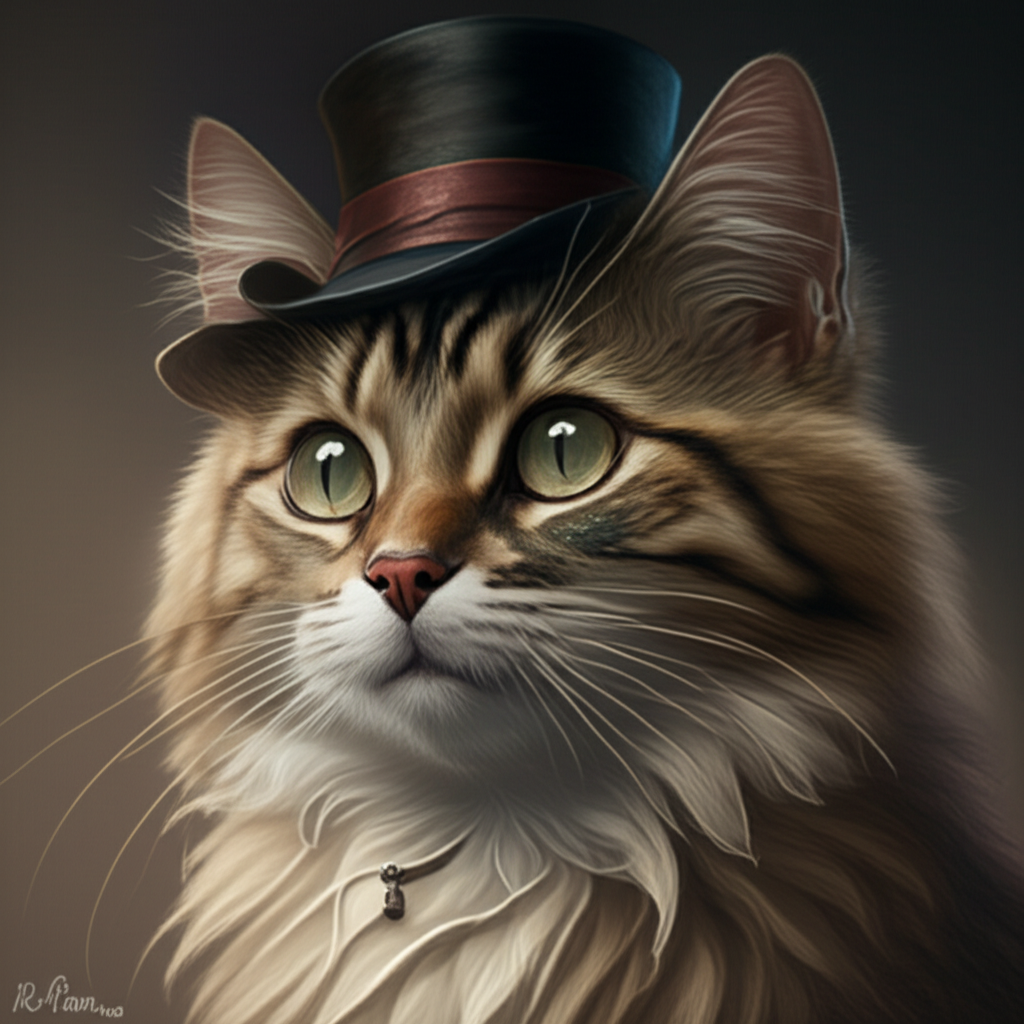

Generating image for: Convert its hat to red


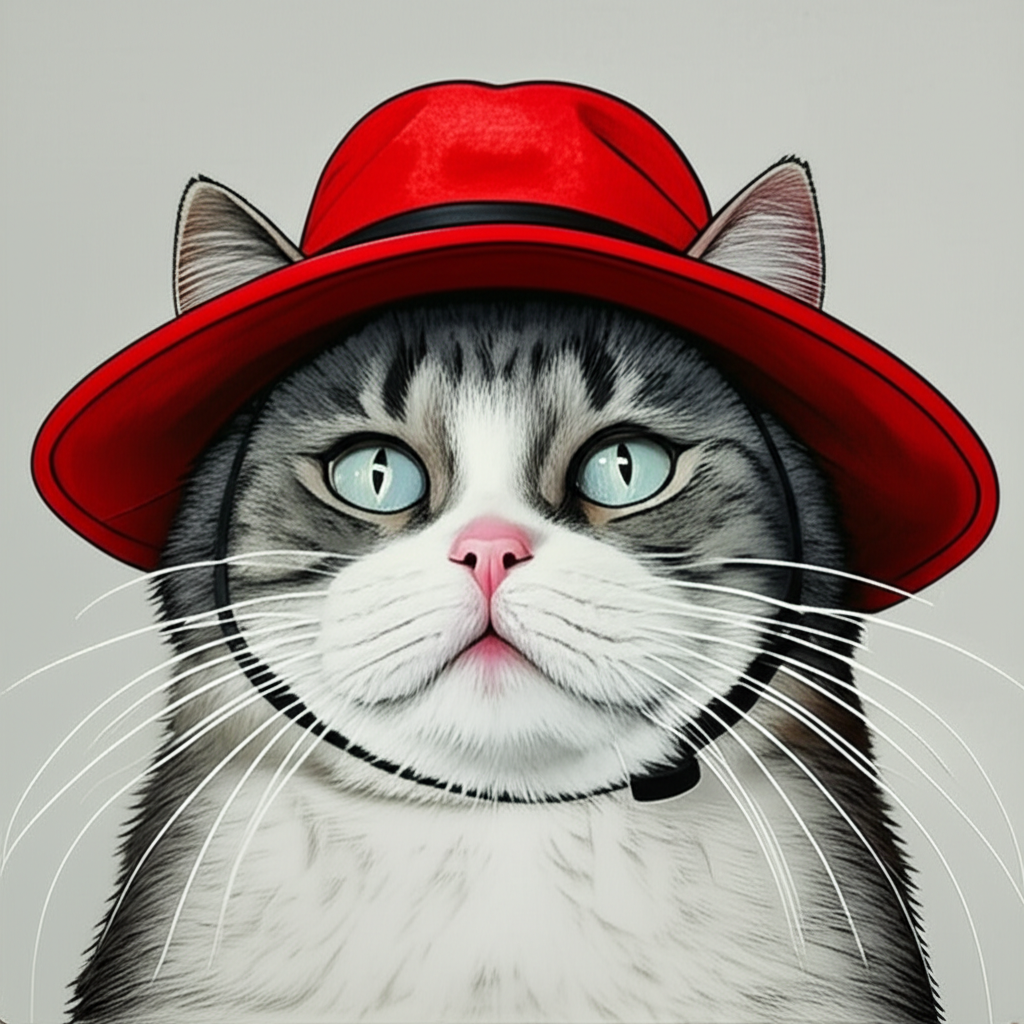

'image_generated'

In [110]:
# handler.conversation
handler.conversation_history = []
handler.generate_image("Draw a image of cat wearing hat")
handler.generate_image("Convert its hat to red")

Generating image for: Draw the same cat as before, with the hat colored black instead of yellow.


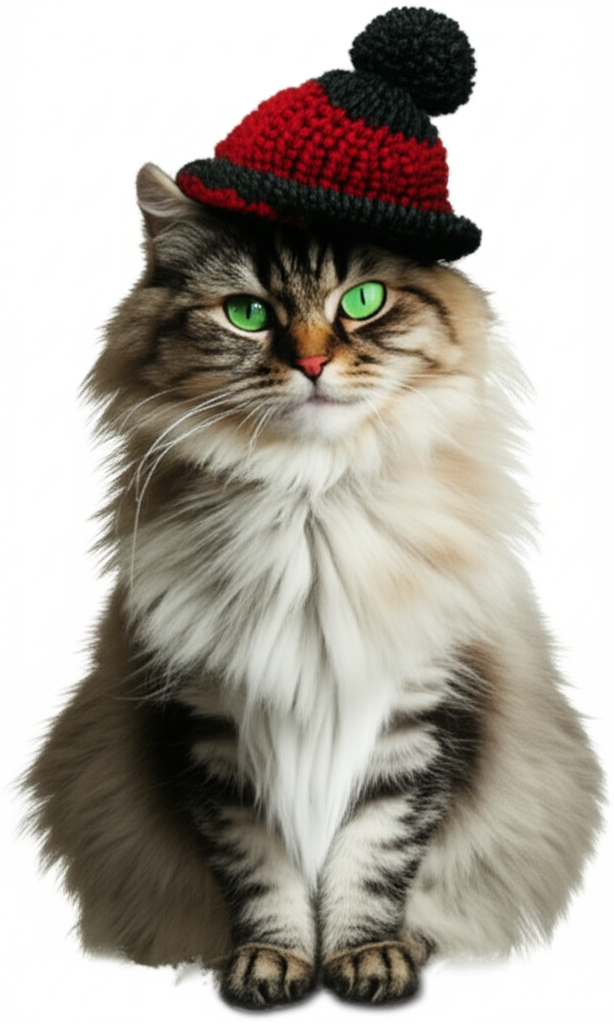

'image_generated'

In [115]:
handler.generate_image("Draw the same cat as before, with the hat colored black instead of yellow.")

In [ ]:
from IPython.display import display, Markdown

# -------------------------
# 1️⃣ Generate Text
# -------------------------
user_prompt_text = "Explain the concept of recursion in programming in simple words."
handler.generate_text(user_prompt_text)
user_prompt_text = "Also mention it's importance"
handler.generate_text(user_prompt_text)






In [ ]:
print("Streaming text response:")
# also printing text
# for partial_text in handler.generate_text_stream(
#     user_input="Explain blockchain in simple terms.",
#     model_name=handler.TEXT_MODEL
# ):
#     print(partial_text)

print("Streaming text response:")
handler.generate_text_stream(
    user_input="Explain blockchain in simple terms.",
    model_name=handler.TEXT_MODEL
)



In [67]:
# -------------------------
# 2️⃣ Generate Audio
# -------------------------
user_prompt_audio = "Say 'Hello! I hope you are having a great day!' in a friendly tone."
audio_result = handler.generate_audio(user_prompt_audio)
print("\n[Audio Result]:", audio_result)



➡️ Using API key: AIzaSyBQqt (Attempt 1)


Input #0, wav, from '/tmp/tmp1lva68av.wav':   0KB sq=    0B 
  Duration: 00:00:04.01, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.78 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 



[Audio Result]: audio_played


   3.96 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Generating image for: Generate a photorealistic image of a cuddly cat wearing a hat.
➡️ Using API key: AIzaSyCGnZ (Attempt 1)


I will generate a photorealistic image of an adorable, fluffy tabby cat with bright green eyes, comfortably nestled on a soft, cream-colored blanket. The cat will be wearing a small, slightly oversized, knitted blue beanie hat that is tilted slightly to the side, adding to its charm. The lighting will be soft and warm, highlighting the texture of the cat's fur and the yarn of the hat.




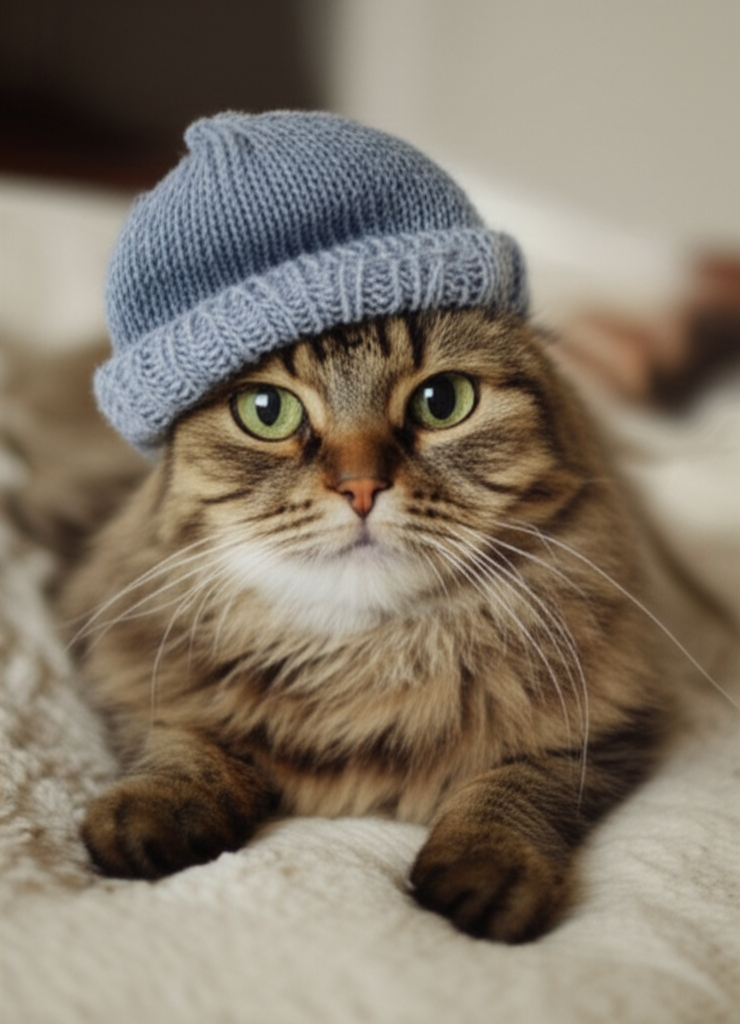

Generating image for: Can you take the same image and make the cat black?
➡️ Using API key: AIzaSyDB-d (Attempt 1)


O


No image returned


In [69]:
# -------------------------
# 3️⃣ Generate Image
# -------------------------
conversation_history = []

resp1 = handler.generate_image("Generate a photorealistic image of a cuddly cat wearing a hat.", IMAGE_MODEL)
resp2 = handler.generate_image("Can you take the same image and make the cat black?", IMAGE_MODEL)



# Image is automatically displayed in the notebook via IPython.display.Image


In [35]:
import base64
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from google.api_core.exceptions import ResourceExhausted, GoogleAPICallError
from IPython.display import Image, display, Audio, Markdown

# Assuming key_utils.py exists and works
from key_utils import get_next_key

import langchain_google_genai.chat_models as chat_mod

class LLMHandler:
    # --- Model Constants ---
    # Using modern, flexible models that support conversation history is recommended
    TEXT_MODEL = "gemini-2.0-flash"
    AUDIO_MODEL = "gemini-2.5-flash-preview-tts"
    IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"
    def __init__(self, system_message="You are a helpful assistant."):
        self.conversation_history = []
        self.system_message = system_message
        self._original_chat_with_retry = chat_mod._chat_with_retry

 # --- Patch retry ---
    def _patch_retry(self, enable_retry: False):
        """Enable or disable internal retry inside LangChain/Google API"""
        if not enable_retry:
            def no_retry_chat_with_retry(**kwargs):
                generation_method = kwargs.pop("generation_method")
                metadata = kwargs.pop("metadata", None)
                return generation_method(
                    request=kwargs.get("request"),
                    retry=None,
                    timeout=None,
                    metadata=metadata
                )
            chat_mod._chat_with_retry = no_retry_chat_with_retry
        else:
            chat_mod._chat_with_retry = self._original_chat_with_retry
        
        # --- Helper: extract base64 image ---
    def _get_image_base64(self, response):
        for block in response.content:
            if isinstance(block, dict) and "image_url" in block:
                return block["image_url"]["url"].split(",")[-1]
        return None

    

    # --- REFACTORED AND FIXED: Message Building ---
    def _build_messages(self, user_input, task_type="text"):
        """
        Correctly builds the message list for the API, preserving history for all task types.
        """
        messages = []

        # FIX: Only add system message for conversational tasks that support it.
        if task_type in ["text", "tool"]:
            messages.append(SystemMessage(content=self.system_message))

        # FIX: Convert the entire history correctly for the model.
        for h in self.conversation_history:
            role = h.get("role")
            content = h.get("content")
            if role == "user":
                messages.append(HumanMessage(content=content))
            elif role == "assistant":
                messages.append(AIMessage(content=content))
        
        # Always add the latest user input.
        messages.append(HumanMessage(content=user_input))
        return messages

    # --- REFACTORED AND FIXED: History Updating ---
    def _update_history(self, user_input, assistant_response_content):
        """
        Correctly updates the internal history with the latest turn.
        """
        self.conversation_history.append({"role": "user", "content": user_input})
        # FIX: Always store the actual content from the assistant.
        self.conversation_history.append({"role": "assistant", "content": assistant_response_content})
    
    def clear_history(self):
        """Helper to reset the conversation."""
        self.conversation_history = []
        print("Conversation history cleared.")


    # --- THE UNIFIED RUN METHOD ---
    def run(self, user_input, task_type="text", tools=None, max_retries=11, enable_retry=False,width=400,height=None):
        """
        A single, unified method to handle text, audio, image, and tool generation.
        This method RETURNS data instead of displaying it.
        """
        self._patch_retry(enable_retry)
        
        # 1. Select the correct model based on the task
        model_name = {
            "text": self.TEXT_MODEL,
            "tool": self.TEXT_MODEL,
            "audio": self.AUDIO_MODEL,
            "image": self.IMAGE_MODEL,
        }.get(task_type, self.TEXT_MODEL)

        # 2. Build the message list correctly
        messages = self._build_messages(user_input, task_type=task_type)
        
        # 3. Centralized Retry Loop
        for attempt in range(max_retries):
            api_key, user_name = get_next_key()
            print(f"➡️ Attempt {attempt + 1}/{max_retries} using key from '{user_name}'...")
            
            try:
                llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=api_key)
                
                # 4. Handle different task types
                if task_type == "audio":
                    tts_message = [HumanMessage(content=user_input)] # Use only the direct input for TTS
                    response = llm.invoke(tts_message, generation_config={"response_modalities": ["AUDIO"]})
                    audio_bytes = response.additional_kwargs.get("audio")
                    self._update_history(user_input, "[Generated audio in response to prompt]")
                    return {"type": "audio", "data": audio_bytes, "text": response.content}

                elif task_type == "image":
                    # For images, we just need the user prompt
                    response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                    image_base64 = self._get_image_base64(response)
                    if image_base64:
                        display(Image(data=base64.b64decode(image_base64), width=width, height=height))
                        # Save only prompt for reference
                        self._update_history(user_input, "[Generated image in response to prompt]")
                        return "image_generated"
                    else:
                        print("No image returned")

                else: # Handles "text" and "tool"
                    model_to_invoke = llm
                    if tools:
                        model_to_invoke = llm.bind_tools(tools, tool_choice="any")
                    
                    response = model_to_invoke.invoke(messages)

                    # Tool Execution Logic
                    if response.tool_calls:
                        messages.append(response)
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            # Find the callable tool function
                            matched_tool_func = next((t for t in tools if getattr(t, '__name__', None) == tool_name), None)
                            if matched_tool_func:
                                result = matched_tool_func(**tool_args)
                                print(f"✅ [TOOL] Called '{tool_name}' with {tool_args}. Result: {result}")
                            else:
                                result = f"Error: Tool '{tool_name}' not found."
                                print(f"❌ [TOOL] {result}")
                            messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
                        
                        # Call the model again with the tool results
                        response = llm.invoke(messages)

                    self._update_history(user_input, response.content)
                    return {"type": "text", "data": response.content, "text": response.content}

            except (ResourceExhausted, GoogleAPICallError, ValueError) as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e.__class__.__name__} - {e}")
                if attempt + 1 >= max_retries:
                    raise RuntimeError("All API keys failed or quota exceeded.") from e
                continue # Try the next key

        raise RuntimeError("All API keys failed or quota exceeded after all attempts.")

        # --- NEW CONVENIENCE METHOD FOR AUDIO ---
    def generate_audio(self, user_input, play_audio=True):
        """
        A convenience method that generates audio and optionally plays it.
        This method acts as a wrapper around the main `run()` method.
        """
        print(f"--- Generating Audio for: '{user_input}' ---")
        response_dict = self.run(user_input, task_type="audio")
        
        if play_audio and response_dict and response_dict.get('type') == 'audio' and response_dict.get('data'):
            print("Audio generation successful. Playing audio...")
            try:
                audio_bytes = response_dict['data']
                audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
                play(audio_segment)
                print("Playback finished.")
            except Exception as e:
                print(f"❌ Error playing audio: {e}")
        elif not response_dict or not response_dict.get('data'):
            print("❌ Audio generation failed or no audio data was returned.")
            return None
            
        return response_dict
        
    #******************************************************************#
    # --- REFINED: GENERATE TRANSCRIPT FROM VIDEO METHOD ---
    #******************************************************************#
    def generate_transcript_from_video(self, file_name, enable_retry=False):
        """
        Transcribes ONLY THE AUDIO TRACK from a video file into text.
    
        Args:
            file_name (str): The path to the video file (e.g., .mp4, .mov, .webm).
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.
    
        Returns:
            str: The transcribed text from the video's audio, or None if an error occurred.
        """
        print(f"--- Transcribing Video AUDIO from: '{file_name}' ---")
    
        if not os.path.exists(file_name):
            print(f"❌ Error: Video file not found at '{file_name}'")
            return None
    
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("video"):
            print(f"❌ Error: Could not determine a valid video MIME type for '{file_name}'")
            return None
        
        with open(file_name, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("utf-8")
    
        # This prompt is now fixed to ONLY ask for transcription
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Please transcribe the audio from this video. Provide only the spoken words as text.",
                },
                {
                    "type": "media",
                    "data": encoded_video,
                    "mime_type": mime_type,
                },
            ]
        )
    
        response_dict = self.run(
            user_input=message,
            task_type="video_transcription", # This task_type is still appropriate
            enable_retry=enable_retry
        )
    
        if response_dict and response_dict.get('type') == 'text':
            return response_dict['text']
        else:
            print("❌ Video transcription failed or no text was returned.")
            return None

In [36]:
# Instantiate the handler once
handler = LLMHandler()


In [30]:
# Assuming your LLMHandler class is defined above and instantiated
# handler = LLMHandler()



# 1. Define the Python functions that the AI can call.
# The docstring is VERY important - it's how the AI knows what the tool does.
def get_current_weather(location: str, unit: str = "celsius"):
    """Gets the current weather for a specified location."""
    
    # In a real app, you would call a weather API. Here, we mock the response.
    print(f"--- TOOL `get_current_weather` EXECUTED for {location} ---")
    if "tokyo" in location.lower():
        return f"The weather in Tokyo is 15 degrees {unit} and sunny."
    elif "san francisco" in location.lower():
        return f"The weather in San Francisco is 12 degrees {unit} and foggy."
    else:
        return f"Sorry, I don't have weather information for {location}."

def get_flight_price(departure: str, destination: str):
    """Gets the flight price between two cities."""

    print(f"--- TOOL `get_flight_price` EXECUTED for {departure} -> {destination} ---")
    return f"The cheapest flight from {departure} to {destination} is $450."

# 2. Create a list of the tool functions.
# The handler will provide this list to the AI.
available_tools = [get_current_weather, get_flight_price]


--- 5. Using Tools ---


In [31]:

# --------------------------------------------------------------------------
# Example 5: Using Tools (Function Calling)
# --------------------------------------------------------------------------
print("\n--- 5. Using Tools ---")

# 3. Write a prompt that requires one of the tools.
tool_prompt = "What's the weather like in Tokyo right now?"
print(f"\n[USER]: {tool_prompt}")


# 4. Call the `run` method with task_type="tool" and the tools list.
# The handler will manage the entire multi-step process automatically.
tool_response = handler.run(
    tool_prompt,
    task_type="tool",
    tools=available_tools
)

# 5. Display the final, natural-language response.
if tool_response and tool_response['type'] == 'text':
    final_answer = tool_response['data']
    print("\n[ASSISTANT's FINAL ANSWER]:")
    display(Markdown(final_answer))

# --- Example of a multi-tool prompt ---
multi_tool_prompt = "I need to know the flight price from San Francisco to Tokyo and what the weather is like there."
print(f"\n[USER]: {multi_tool_prompt}")

multi_tool_response = handler.run(
    multi_tool_prompt,
    task_type="tool",
    tools=available_tools
)

if multi_tool_response:
    print("\n[ASSISTANT's FINAL ANSWER]:")
    display(Markdown(multi_tool_response['data']))


--- 5. Using Tools ---

[USER]: What's the weather like in Tokyo right now?
➡️ Attempt 1/5 using key from 'sijan.paudel10'...
--- TOOL `get_current_weather` EXECUTED for Tokyo ---
✅ [TOOL] Called 'get_current_weather' with {'location': 'Tokyo'}. Result: The weather in Tokyo is 15 degrees celsius and sunny.

[ASSISTANT's FINAL ANSWER]:


The weather in Tokyo is 15 degrees Celsius and sunny.


[USER]: I need to know the flight price from San Francisco to Tokyo and what the weather is like there.
➡️ Attempt 1/5 using key from 'paudelsijan15'...
--- TOOL `get_flight_price` EXECUTED for San Francisco -> Tokyo ---
✅ [TOOL] Called 'get_flight_price' with {'departure': 'San Francisco', 'destination': 'Tokyo'}. Result: The cheapest flight from San Francisco to Tokyo is $450.
--- TOOL `get_current_weather` EXECUTED for Tokyo ---
✅ [TOOL] Called 'get_current_weather' with {'location': 'Tokyo'}. Result: The weather in Tokyo is 15 degrees celsius and sunny.

[ASSISTANT's FINAL ANSWER]:


Okay! The cheapest flight I found from San Francisco to Tokyo is $450. The weather in Tokyo is currently 15 degrees Celsius and sunny.

In [29]:
# --- Text Example ---
print("\n--- TEXT ---")
response = handler.run("Hello! Tell me a fun fact.")
if response['type'] == 'text':
    display(Markdown(response['data']))

# --- Conversational Text Example ---
print("\n--- CONVERSATIONAL TEXT ---")
response = handler.run("That's cool! Elaborate it more.")
if response['type'] == 'text':
    display(Markdown(response['data']))



--- TEXT ---
➡️ Attempt 1/5 using key from 'saharamanandhar'...


Okay, here's a fun fact for you:

Honey never spoils! Archaeologists have found pots of honey in ancient Egyptian tombs that are over 3,000 years old and still perfectly edible. This is due to its low water content, high acidity, and the presence of hydrogen peroxide.


--- CONVERSATIONAL TEXT ---
➡️ Attempt 1/5 using key from 'sijanpaudel'...


Alright, let's dive deeper into why honey is so remarkably resistant to spoilage:

*   **Low Water Content:** Honey is naturally hygroscopic, meaning it attracts and absorbs moisture from the air. However, the water content in properly processed honey is very low, typically around 17-20%. This low water content is crucial because bacteria and microorganisms need water to survive and multiply. Without enough water, they can't thrive in honey.

*   **High Acidity (Low pH):** Honey is acidic, with a pH usually ranging from 3.5 to 4.5. This acidic environment is inhospitable to most bacteria and microorganisms. They simply can't survive in such an acidic condition. The acidity comes from the presence of gluconic acid, which is produced by an enzyme called glucose oxidase that bees add to nectar.

*   **Hydrogen Peroxide:** The same enzyme, glucose oxidase, also produces small amounts of hydrogen peroxide (H2O2) as a byproduct. Hydrogen peroxide is a well-known antiseptic and antibacterial agent. While the concentration of hydrogen peroxide in honey is low, it's enough to inhibit the growth of many microorganisms. The production of hydrogen peroxide is slow and continuous when the honey is diluted slightly, which is why some people use honey to treat wounds.

*   **Bees' Defense Mechanism:** Bees also contribute to honey's preservation through their own enzymes and processes. They add the enzyme glucose oxidase to the nectar, as mentioned above, and they also remove a significant amount of water from the nectar by fanning their wings, which helps to concentrate the sugars and reduce the water content.

*   **Proper Sealing:** While honey itself is incredibly stable, proper storage is still important to prevent it from absorbing too much moisture from the air. This is why honey is often stored in airtight containers. If honey absorbs too much moisture, it can ferment, although even fermented honey is still generally safe to eat, just with a different flavor.

So, the combination of low water content, high acidity, hydrogen peroxide, and the bees' natural processes creates a remarkably stable and long-lasting food. That's why those archaeologists found edible honey in ancient tombs! It's a testament to the amazing properties of this natural sweetener.

In [ ]:
# --- Audio Example ---
print("\n--- AUDIO ---")
response = handler.run("This is a test of the text to speech system.", task_type="audio")
print(response)

Conversation history cleared.

--- IMAGE ---
Conversation history cleared.
➡️ Attempt 1/5 using key from 'iamengineer'...


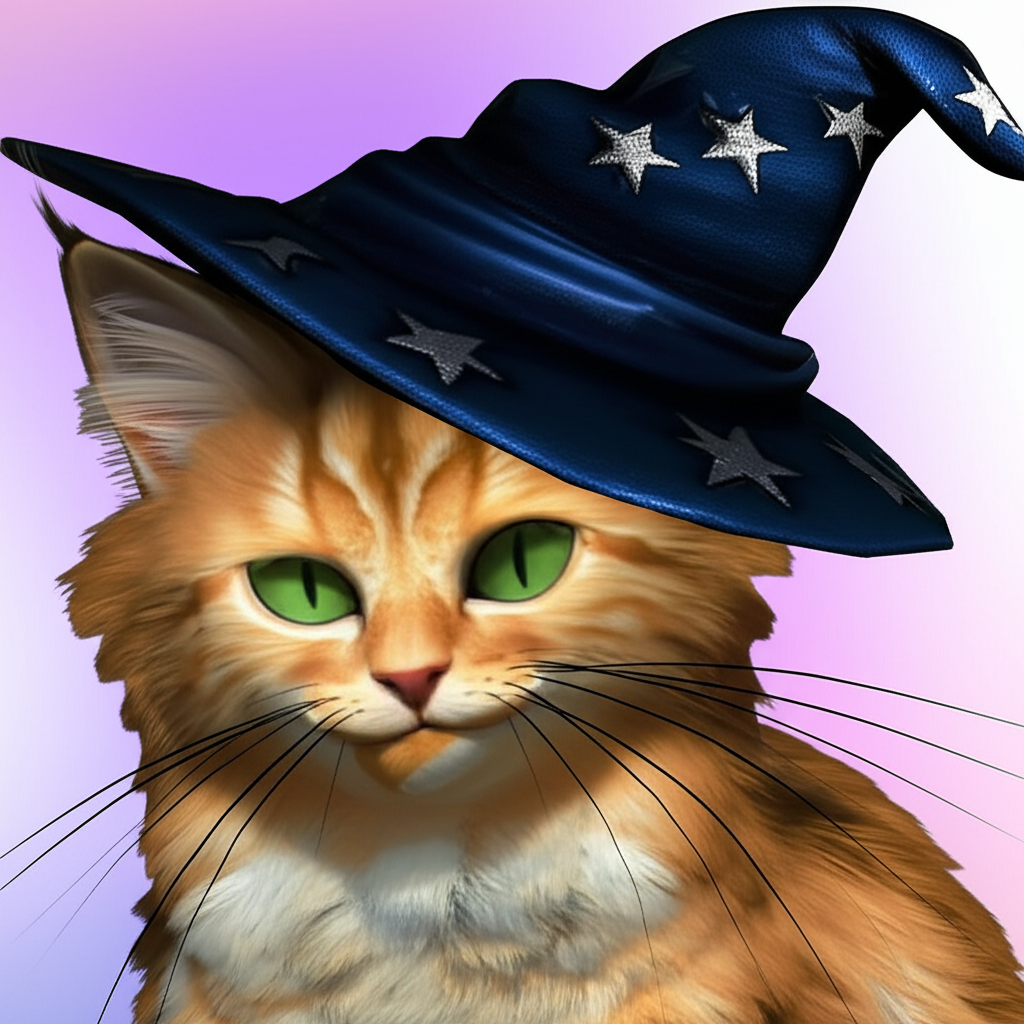

➡️ Attempt 1/5 using key from 'birajmohanta'...
No image returned
➡️ Attempt 2/5 using key from 'saharamanandhar'...


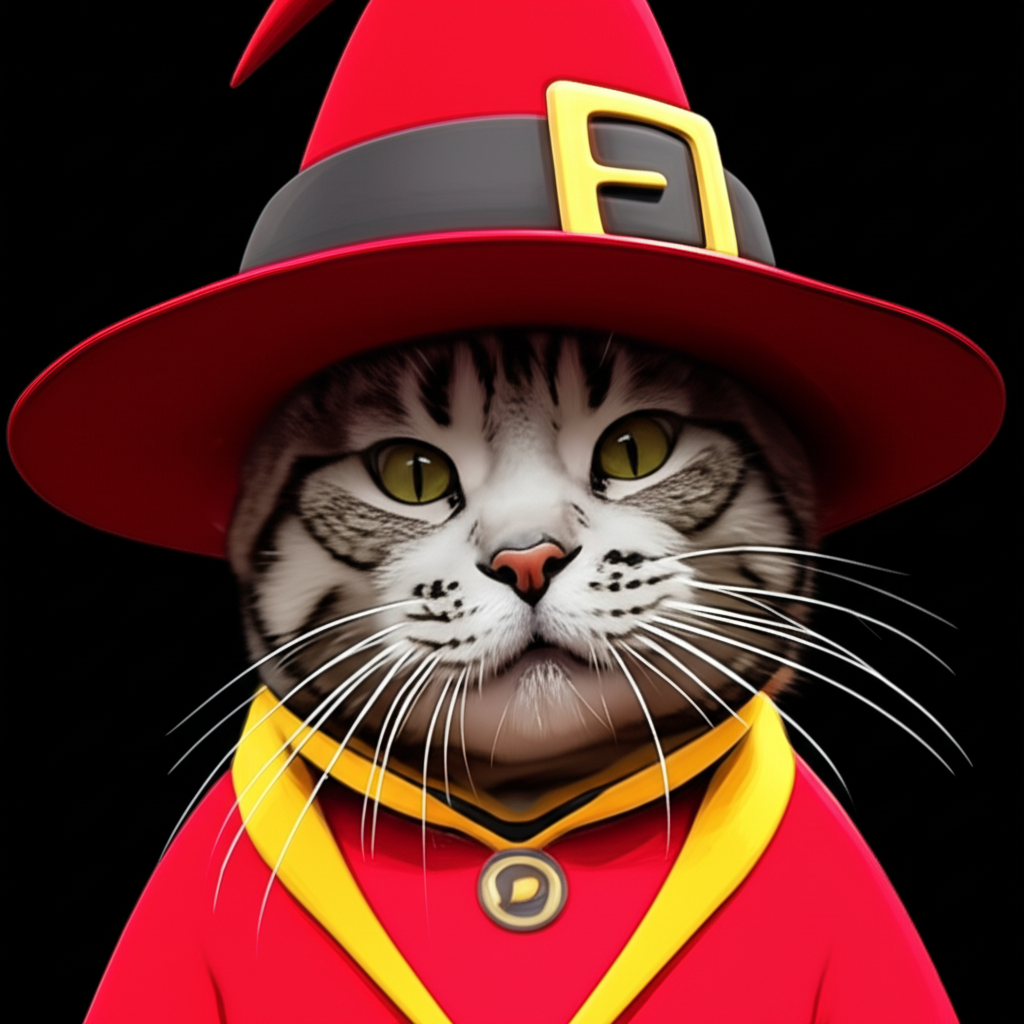

In [37]:
handler.clear_history()
# --- Image Example ---
print("\n--- IMAGE ---")
handler.clear_history()
response = handler.run("A cute cat wearing a wizard hat", task_type="image")
response = handler.run("Make it wear a red hat",task_type="image")


In [46]:
# ----------------------------
# 6️⃣ TEXT WITH TOOLS
# ----------------------------
print("=== TEXT WITH TOOLS ===")
# Define tools as list
def get_ticket_price(destination_city):
    prices = {"paris": "$120", "berlin": "$150"}
    return prices.get(destination_city.lower(), "Price unknown")

tools = [get_ticket_price]


=== TEXT WITH TOOLS ===


In [47]:
response = handler.run("What is the price to Paris",tools=tools,task_type="text")
print(response["data"])
response = handler.run("and to berlin?", tools=tools,task_type="text")

➡️ Attempt 1/5 using key from 'prabeshsubedi'...
✅ [TOOL] Called 'get_ticket_price' with {'destination_city': 'Paris'}. Result: $120
The price to Paris is $120.
➡️ Attempt 1/5 using key from 'sandeshtiwari'...
✅ [TOOL] Called 'get_ticket_price' with {'destination_city': 'berlin'}. Result: $150


In [37]:
import base64
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from google.api_core.exceptions import ResourceExhausted, GoogleAPICallError
from IPython.display import Image, display, Audio, Markdown
import mimetypes

# Assuming key_utils.py exists and works
from key_utils import get_next_key

import langchain_google_genai.chat_models as chat_mod

class LLMHandler:
    # --- Model Constants ---
    # Using modern, flexible models that support conversation history is recommended
    TEXT_MODEL = "gemini-2.0-flash"
    AUDIO_MODEL = "gemini-2.5-flash-preview-tts"
    IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"
    def __init__(self, system_message="You are a helpful assistant."):
        self.conversation_history = []
        self.system_message = system_message
        self._original_chat_with_retry = chat_mod._chat_with_retry

 # --- Patch retry ---
    def _patch_retry(self, enable_retry: False):
        """Enable or disable internal retry inside LangChain/Google API"""
        if not enable_retry:
            def no_retry_chat_with_retry(**kwargs):
                generation_method = kwargs.pop("generation_method")
                metadata = kwargs.pop("metadata", None)
                return generation_method(
                    request=kwargs.get("request"),
                    retry=None,
                    timeout=None,
                    metadata=metadata
                )
            chat_mod._chat_with_retry = no_retry_chat_with_retry
        else:
            chat_mod._chat_with_retry = self._original_chat_with_retry
        
        # --- Helper: extract base64 image ---
    def _get_image_base64(self, response):
        for block in response.content:
            if isinstance(block, dict) and "image_url" in block:
                return block["image_url"]["url"].split(",")[-1]
        return None

    

    # --- REFACTORED AND FIXED: Message Building ---
    def _build_messages(self, user_input, task_type="text"):
        """
        Correctly builds the message list for the API, preserving history for all task types.
        """
        messages = []

        # FIX: Only add system message for conversational tasks that support it.
        if task_type in ["text", "tool"]:
            messages.append(SystemMessage(content=self.system_message))

        # FIX: Convert the entire history correctly for the model.
        for h in self.conversation_history:
            role = h.get("role")
            content = h.get("content")
            if role == "user":
                messages.append(HumanMessage(content=content))
            elif role == "assistant":
                messages.append(AIMessage(content=content))
        
        # Always add the latest user input.
        messages.append(HumanMessage(content=user_input))
        return messages

    # --- REFACTORED AND FIXED: History Updating ---
    def _update_history(self, user_input, assistant_response_content):
        """
        Correctly updates the internal history with the latest turn.
        """
        self.conversation_history.append({"role": "user", "content": user_input})
        # FIX: Always store the actual content from the assistant.
        self.conversation_history.append({"role": "assistant", "content": assistant_response_content})
    
    def clear_history(self):
        """Helper to reset the conversation."""
        self.conversation_history = []
        print("Conversation history cleared.")


    # --- THE UNIFIED RUN METHOD ---
    def run(self, user_input, task_type="text", tools=None, max_retries=11, enable_retry=False,width=400,height=None):
        """
        A single, unified method to handle text, audio, image, and tool generation.
        This method RETURNS data instead of displaying it.
        """
        self._patch_retry(enable_retry)
        
                # 1. Select model
        model_name = {
            "text": self.TEXT_MODEL,
            "tool": self.TEXT_MODEL,
            "audio": self.AUDIO_MODEL,
            "image": self.IMAGE_MODEL,
            "audio_transcription": self.TEXT_MODEL,
            "video_transcription": self.TEXT_MODEL,
            "image_analysis": self.TEXT_MODEL, #Use the multimodal model for transcription
        }.get(task_type, self.TEXT_MODEL)

        # 2. Build messages (with a special case for transcription)
        if task_type in ["audio_transcription", "video_transcription",  "image_analysis"]:
            # For transcription, the user_input is already a fully formed HumanMessage
            messages = [user_input]
        else:
            messages = self._build_messages(user_input, task_type=task_type)
        
        # 3. Centralized Retry Loop
        for attempt in range(max_retries):
            api_key, user_name = get_next_key()
            print(f"➡️ Attempt {attempt + 1}/{max_retries} using key from '{user_name}'...")
            
            try:
                llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=api_key)
                
                # 4. Handle different task types
                if task_type == "audio":
                    tts_message = [HumanMessage(content=user_input)] # Use only the direct input for TTS
                    response = llm.invoke(tts_message, generation_config={"response_modalities": ["AUDIO"]})
                    audio_bytes = response.additional_kwargs.get("audio")
                    self._update_history(user_input, "[Generated audio in response to prompt]")
                    return {"type": "audio", "data": audio_bytes, "text": response.content}

                elif task_type == "image":
                    # For images, we just need the user prompt
                    response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                    image_base64 = self._get_image_base64(response)
                    if image_base64:
                        display(Image(data=base64.b64decode(image_base64), width=width, height=height))
                        # Save only prompt for reference
                        self._update_history(user_input, "[Generated image in response to prompt]")
                        print( "image_generated")
                        return {"type": "image", "data": image_base64, "text": "Image generated successfully."}
                    else:
                        print("No image returned")

                else: # Handles "text" and "tool" and "audio_transcription"
                    model_to_invoke = llm
                    if tools:
                        model_to_invoke = llm.bind_tools(tools, tool_choice="any")
                    
                    response = model_to_invoke.invoke(messages)

                    # Tool Execution Logic
                    if response.tool_calls:
                        messages.append(response)
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            # Find the callable tool function
                            matched_tool_func = next((t for t in tools if getattr(t, '__name__', None) == tool_name), None)
                            if matched_tool_func:
                                result = matched_tool_func(**tool_args)
                                print(f"✅ [TOOL] Called '{tool_name}' with {tool_args}. Result: {result}")
                            else:
                                result = f"Error: Tool '{tool_name}' not found."
                                print(f"❌ [TOOL] {result}")
                            messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
                        
                        # Call the model again with the tool results
                        response = llm.invoke(messages)
                     # UPDATED: Differentiated history logging
                    if task_type == ["audio_transcription","video_transcription"]:
                        prompt_summary = f"[Transcription requested for an media file]"
                        self._update_history(prompt_summary, response.content)
                    elif task_type == "image_analysis":
                         # Extract the text part of the prompt for a better history log
                        prompt_text = next((part['text'] for part in user_input.content if isinstance(part, dict) and part['type'] == 'text'), 'Analyze image')
                        prompt_summary = f"[{prompt_text}]"
                        self._update_history(prompt_summary, response.content)
                    else:
                        self._update_history(user_input, response.content)
                        

                return {"type": "text", "data": response.content, "text": response.content}

            except (ResourceExhausted, GoogleAPICallError, ValueError) as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e.__class__.__name__} - {e}")
                if attempt + 1 >= max_retries:
                    raise RuntimeError("All API keys failed or quota exceeded.") from e
                continue # Try the next key

        raise RuntimeError("All API keys failed or quota exceeded after all attempts.")
    #******************************************************************#
    # --- NEW: GENERATE AUDIO FROM TEXT METHOD ---
    #******************************************************************#
    def generate_audio(self, user_input, play_audio=True):
        """
        A convenience method that generates audio and optionally plays it.
        This method acts as a wrapper around the main `run()` method.
        """
        print(f"--- Generating Audio for: '{user_input}' ---")
        response_dict = self.run(user_input, task_type="audio")
        
        if play_audio and response_dict and response_dict.get('type') == 'audio' and response_dict.get('data'):
            print("Audio generation successful. Playing audio...")
            try:
                audio_bytes = response_dict['data']
                audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
                play(audio_segment)
                print("Playback finished.")
            except Exception as e:
                print(f"❌ Error playing audio: {e}")
        elif not response_dict or not response_dict.get('data'):
            print("❌ Audio generation failed or no audio data was returned.")
            return None
            
        return response_dict
        
    #******************************************************************#
    # --- NEW: GENERATE TEXT FROM AUDIO METHOD ---
    #******************************************************************#
    def generate_text_from_audio(self, file_name, enable_retry=False):
        """
        Transcribes an audio file into text using a multimodal model.

        Args:
            file_name (str): The path to the audio file (e.g., .mp3, .wav, .flac).
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.

        Returns:
            str: The transcribed text from the audio, or None if an error occurred.
        """
        print(f"--- Transcribing Audio from: '{file_name}' ---")

        if not os.path.exists(file_name):
            print(f"❌ Error: Audio file not found at '{file_name}'")
            return None

        # 1. Automatically detect MIME type
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("audio"):
            print(f"❌ Error: Could not determine a valid audio MIME type for '{file_name}'")
            return None
        
        print(f"Detected MIME type: {mime_type}")

        # 2. Read file and encode in base64
        with open(file_name, "rb") as audio_file:
            encoded_audio = base64.b64encode(audio_file.read()).decode("utf-8")

        # 3. Construct the special multimodal message
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Transcribe the audio and provide the full text.",
                },
                {
                    "type": "media",
                    "data": encoded_audio,
                    "mime_type": mime_type,
                },
            ]
        )

        # 4. Call the main run method with the new task type
        response_dict = self.run(
            user_input=message,
            task_type="audio_transcription",
            enable_retry=enable_retry
        )

        if response_dict and response_dict.get('type') == 'text':
            return response_dict['text']
        else:
            print("❌ Audio transcription failed or no text was returned.")
            return None

    #******************************************************************#
    # --- REFINED: GENERATE TRANSCRIPT FROM VIDEO METHOD ---
    #******************************************************************#
    def generate_transcript_from_video(self, file_name, enable_retry=False):
        """
        Transcribes ONLY THE AUDIO TRACK from a video file into text.
    
        Args:
            file_name (str): The path to the video file (e.g., .mp4, .mov, .webm).
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.
    
        Returns:
            str: The transcribed text from the video's audio, or None if an error occurred.
        """
        print(f"--- Transcribing Video AUDIO from: '{file_name}' ---")
    
        if not os.path.exists(file_name):
            print(f"❌ Error: Video file not found at '{file_name}'")
            return None
    
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("video"):
            print(f"❌ Error: Could not determine a valid video MIME type for '{file_name}'")
            return None
        
        with open(file_name, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("utf-8")
    
        # This prompt is now fixed to ONLY ask for transcription
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Please transcribe the audio from this video. Provide only the spoken words as text.",
                },
                {
                    "type": "media",
                    "data": encoded_video,
                    "mime_type": mime_type,
                },
            ]
        )
    
        response_dict = self.run(
            user_input=message,
            task_type="video_transcription", # This task_type is still appropriate
            enable_retry=enable_retry
        )
    
        if response_dict and response_dict.get('type') == 'text':
            return response_dict['text']
        else:
            print("❌ Video transcription failed or no text was returned.")
            return None

    #******************************************************************#
    # --- NEW: GENERATE TEXT FROM IMAGE METHOD ---
    #******************************************************************#
    def generate_text_from_image(self, image_source, prompt="Describe this image in detail.", enable_retry=False):
        """
        Analyzes an image and generates a textual description or answer.

        Args:
            image_source (str): The path to a local image file OR a public URL to an image.
            prompt (str): The question or command for the model regarding the image.
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.

        Returns:
            str: The text generated by the model, or None if an error occurred.
        """
        print(f"--- Analyzing Image from: '{image_source[:70]}...' ---")
        image_url_content = ""

        # 1. Check if the source is a URL or a local file
        if image_source.startswith("http://") or image_source.startswith("https://"):
            image_url_content = image_source
        elif os.path.exists(image_source):
            # It's a local file, so we need to encode it
            mime_type, _ = mimetypes.guess_type(image_source)
            if not mime_type or not mime_type.startswith("image"):
                print(f"❌ Error: Could not determine a valid image MIME type for '{image_source}'")
                return None
            
            with open(image_source, "rb") as image_file:
                encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
            
            image_url_content = f"data:{mime_type};base64,{encoded_image}"
        else:
            print(f"❌ Error: Image file not found at '{image_source}'")
            return None

        # 2. Construct the special multimodal message
        message = HumanMessage(
            content=[
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": image_url_content},
            ]
        )
        
        # 3. Call the main run method with the new task type
        response_dict = self.run(
            user_input=message,
            task_type="image_analysis",
            enable_retry=enable_retry
        )

        if response_dict and response_dict.get('type') == 'text':
            return response_dict
        else:
            print("❌ Image analysis failed or no text was returned.")
            return None

    #******************************************************************#
    # --- NEW: ANALYZE VIDEO VISUALLY (VIDEO UNDERSTANDING) ---
    #******************************************************************#
    def analyze_video(self, file_name, prompt="Describe this video in detail, frame by frame.", enable_retry=False):
        """
        Performs multimodal analysis on a video, understanding its visual frames and audio.
    
        Args:
            file_name (str): The path to the video file (e.g., .mp4, .mov, .webm).
            prompt (str): The specific question or command for the model regarding the video's content.
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.
    
        Returns:
            dict: The full response dictionary from the model, or None if an error occurred.
        """
        print(f"--- Analyzing Video VISUALLY from: '{file_name}' with prompt: '{prompt}' ---")
    
        if not os.path.exists(file_name):
            print(f"❌ Error: Video file not found at '{file_name}'")
            return None
    
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("video"):
            print(f"❌ Error: Could not determine a valid video MIME type for '{file_name}'")
            return None
        
        with open(file_name, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("utf-8")
    
        # This prompt is now DYNAMIC and comes from the user
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": prompt, # Use the flexible prompt here
                },
                {
                    "type": "media",
                    "data": encoded_video,
                    "mime_type": mime_type,
                },
            ]
        )
    
        # We can reuse the "video_transcription" task_type in the run method,
        # as the logic for handling a HumanMessage with media is the same.
        # Or you could create a new "video_analysis" task_type if you want
        # separate logging logic inside the run method.
        response_dict = self.run(
            user_input=message,
            task_type="video_transcription",
            enable_retry=enable_retry
        )
    
        if response_dict and response_dict.get('type') == 'text':
            return response_dict
        else:
            print("❌ Video analysis failed or no text was returned.")
            return None
    


In [1]:
import base64
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from google.api_core.exceptions import ResourceExhausted, GoogleAPICallError
from IPython.display import Image as IpyImage, display, Audio, Markdown
import mimetypes
import os

# Assuming key_utils.py exists and works
from key_utils import get_next_key

import langchain_google_genai.chat_models as chat_mod

class LLMHandler:
    # --- Model Constants ---
    # Using modern, flexible models that support conversation history is recommended
    TEXT_MODEL = "gemini-2.0-flash"
    AUDIO_MODEL = "gemini-2.5-flash-preview-tts"
    IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"
    def __init__(self, system_message="You are a helpful assistant."):
        self.conversation_history = []
        self.system_message = system_message
        self._original_chat_with_retry = chat_mod._chat_with_retry

 # --- Patch retry ---
    def _patch_retry(self, enable_retry: False):
        """Enable or disable internal retry inside LangChain/Google API"""
        if not enable_retry:
            def no_retry_chat_with_retry(**kwargs):
                generation_method = kwargs.pop("generation_method")
                metadata = kwargs.pop("metadata", None)
                return generation_method(
                    request=kwargs.get("request"),
                    retry=None,
                    timeout=None,
                    metadata=metadata
                )
            chat_mod._chat_with_retry = no_retry_chat_with_retry
        else:
            chat_mod._chat_with_retry = self._original_chat_with_retry
        
        # --- Helper: extract base64 image ---
    def _get_image_base64(self, response):
        for block in response.content:
            if isinstance(block, dict) and "image_url" in block:
                return block["image_url"]["url"].split(",")[-1]
        return None

    

    # --- REFACTORED AND FIXED: Message Building ---
    def _build_messages(self, user_input, task_type="text"):
        """
        Correctly builds the message list for the API, preserving history for all task types.
        """
        messages =[]
        # FIX: Only add system message for conversational tasks that support it.
        if task_type in ["text", "tool"]:
            messages.append(SystemMessage(content=self.system_message))
    
        # FIX: Convert the entire history correctly for the model.
        for h in self.conversation_history:
            role = h.get("role")
            content = h.get("content")

            # --- DEFENSIVE CHECK AND FIX ---
            # If content is a LangChain message object, extract its 'content' attribute.
            # This prevents the ValidationError crash.
            if hasattr(content, 'content'):
                print("⚠️ [DEBUG] Found a message object in history. Extracting its content.")
                content = content.content
            # --- END OF FIX ---

            if role == "user":
                messages.append(HumanMessage(content=content))
            elif role == "assistant":
                messages.append(AIMessage(content=content))
        
        # Always add the latest user input.
        messages.append(HumanMessage(content=user_input))
        return messages

    # --- REFACTORED AND FIXED: History Updating ---
    def _update_history(self, user_input, assistant_response_content):
        """
        Correctly updates the internal history with the latest turn.
        """
        self.conversation_history.append({"role": "user", "content": user_input})
        # FIX: Always store the actual content from the assistant.
        self.conversation_history.append({"role": "assistant", "content": assistant_response_content})
    
    def clear_history(self):
        """Helper to reset the conversation."""
        self.conversation_history = []
        print("Conversation history cleared.")


    # --- THE UNIFIED RUN METHOD ---
    def run(self, user_input, task_type="text", tools=None, max_retries=11, enable_retry=False,width=400,height=None):
        """
        A single, unified method to handle text, audio, image, and tool generation.
        This method RETURNS data instead of displaying it.
        """
        self._patch_retry(enable_retry)
        
                # 1. Select model
        model_name = {
            "text": self.TEXT_MODEL,
            "tool": self.TEXT_MODEL,
            "audio": self.AUDIO_MODEL,
            "image": self.IMAGE_MODEL,
            "audio_transcription": self.TEXT_MODEL,
            "video_transcription": self.TEXT_MODEL,
            "image_analysis": self.TEXT_MODEL, #Use the multimodal model for transcription
        }.get(task_type, self.TEXT_MODEL)

        # 2. Build messages (with a special case for transcription)
        if task_type in ["audio_transcription", "video_transcription",  "image_analysis"]:
            # For transcription, the user_input is already a fully formed HumanMessage
            messages = [user_input]
        else:
            messages = self._build_messages(user_input, task_type=task_type)
        
        # 3. Centralized Retry Loop
        for attempt in range(max_retries):
            api_key, user_name = get_next_key()
            print(f"➡️ Attempt {attempt + 1}/{max_retries} using key from '{user_name}'...")
            
            try:
                llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=api_key)
                
                # 4. Handle different task types
                if task_type == "audio":
                    tts_message = [HumanMessage(content=user_input)] # Use only the direct input for TTS
                    response = llm.invoke(tts_message, generation_config={"response_modalities": ["AUDIO"]})
                    audio_bytes = response.additional_kwargs.get("audio")
                    self._update_history(user_input, "[Generated audio in response to prompt]")
                    return {"type": "audio", "data": audio_bytes, "text": response.content}

                elif task_type == "image":
                    # For images, we just need the user prompt
                    response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                    image_base64 = self._get_image_base64(response)
                    if image_base64:
                        display(IpyImage(data=base64.b64decode(image_base64), width=width, height=height))
                        # Save only prompt for reference
                        self._update_history(user_input, "[Generated image in response to prompt]")
                        print( "image_generated")
                        return {"type": "image", "data": image_base64, "text": "Image generated successfully."}
                    else:
                        print("No image returned")

                else: # Handles "text" and "tool" and "audio_transcription"
                    model_to_invoke = llm
                    if tools:
                        model_to_invoke = llm.bind_tools(tools, tool_choice="any")
                    
                    response = model_to_invoke.invoke(messages)

                    # Tool Execution Logic
                    if response.tool_calls:
                        messages.append(response)
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            # Find the callable tool function
                            matched_tool_func = next((t for t in tools if getattr(t, '__name__', None) == tool_name), None)
                            if matched_tool_func:
                                result = matched_tool_func(**tool_args)
                                print(f"✅ [TOOL] Called '{tool_name}' with {tool_args}. Result: {result}")
                            else:
                                result = f"Error: Tool '{tool_name}' not found."
                                print(f"❌ [TOOL] {result}")
                            messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
                        
                        # Call the model again with the tool results
                        response = llm.invoke(messages)
                     # UPDATED: Differentiated history logging
                    if task_type == ["audio_transcription","video_transcription"]:
                        prompt_summary = f"[Transcription requested for an media file]"
                        self._update_history(prompt_summary, response.content)
                    elif task_type == "image_analysis":
                         # Extract the text part of the prompt for a better history log
                        prompt_text = next((part['text'] for part in user_input.content if isinstance(part, dict) and part['type'] == 'text'), 'Analyze image')
                        prompt_summary = f"[{prompt_text}]"
                        self._update_history(prompt_summary, response.content)
                    else:
                        self._update_history(user_input, response.content)
                        

                return {"type": "text", "data": response.content, "text": response.content}

            except (ResourceExhausted, GoogleAPICallError, ValueError) as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e.__class__.__name__} - {e}")
                if attempt + 1 >= max_retries:
                    raise RuntimeError("All API keys failed or quota exceeded.") from e
                continue # Try the next key

        raise RuntimeError("All API keys failed or quota exceeded after all attempts.")
    #******************************************************************#
    # --- NEW: GENERATE AUDIO FROM TEXT METHOD ---
    #******************************************************************#
    def generate_audio(self, user_input, play_audio=True):
        """
        A convenience method that generates audio and optionally plays it.
        This method acts as a wrapper around the main `run()` method.
        """
        print(f"--- Generating Audio for: '{user_input}' ---")
        response_dict = self.run(user_input, task_type="audio")
        
        if play_audio and response_dict and response_dict.get('type') == 'audio' and response_dict.get('data'):
            print("Audio generation successful. Playing audio...")
            try:
                audio_bytes = response_dict['data']
                audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
                play(audio_segment)
                print("Playback finished.")
            except Exception as e:
                print(f"❌ Error playing audio: {e}")
        elif not response_dict or not response_dict.get('data'):
            print("❌ Audio generation failed or no audio data was returned.")
            return None
            
        return response_dict
        
    #******************************************************************#
    # --- NEW: GENERATE TEXT FROM AUDIO METHOD ---
    #******************************************************************#
    def generate_text_from_audio(self, file_name, enable_retry=False):
        """
        Transcribes an audio file into text using a multimodal model.

        Args:
            file_name (str): The path to the audio file (e.g., .mp3, .wav, .flac).
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.

        Returns:
            str: The transcribed text from the audio, or None if an error occurred.
        """
        print(f"--- Transcribing Audio from: '{file_name}' ---")

        if not os.path.exists(file_name):
            print(f"❌ Error: Audio file not found at '{file_name}'")
            return None

        # 1. Automatically detect MIME type
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("audio"):
            print(f"❌ Error: Could not determine a valid audio MIME type for '{file_name}'")
            return None
        
        print(f"Detected MIME type: {mime_type}")

        # 2. Read file and encode in base64
        with open(file_name, "rb") as audio_file:
            encoded_audio = base64.b64encode(audio_file.read()).decode("utf-8")

        # 3. Construct the special multimodal message
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Transcribe the audio and provide the full text.",
                },
                {
                    "type": "media",
                    "data": encoded_audio,
                    "mime_type": mime_type,
                },
            ]
        )

        # 4. Call the main run method with the new task type
        response_dict = self.run(
            user_input=message,
            task_type="audio_transcription",
            enable_retry=enable_retry
        )

        if response_dict and response_dict.get('type') == 'text':
            return response_dict['text']
        else:
            print("❌ Audio transcription failed or no text was returned.")
            return None


    #******************************************************************#
    # --- REFINED: GENERATE TRANSCRIPT FROM VIDEO METHOD ---
    #******************************************************************#
    def generate_transcript_from_video(self, file_name, enable_retry=False):
        """
        Transcribes ONLY THE AUDIO TRACK from a video file into text.
    
        Args:
            file_name (str): The path to the video file (e.g., .mp4, .mov, .webm).
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.
    
        Returns:
            str: The transcribed text from the video's audio, or None if an error occurred.
        """
        print(f"--- Transcribing Video AUDIO from: '{file_name}' ---")
    
        if not os.path.exists(file_name):
            print(f"❌ Error: Video file not found at '{file_name}'")
            return None
    
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("video"):
            print(f"❌ Error: Could not determine a valid video MIME type for '{file_name}'")
            return None
        
        with open(file_name, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("utf-8")
    
        # This prompt is now fixed to ONLY ask for transcription
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Please transcribe the audio from this video. Provide only the spoken words as text.",
                },
                {
                    "type": "media",
                    "data": encoded_video,
                    "mime_type": mime_type,
                },
            ]
        )
    
        response_dict = self.run(
            user_input=message,
            task_type="video_transcription", # This task_type is still appropriate
            enable_retry=enable_retry
        )
    
        if response_dict and response_dict.get('type') == 'text':
            return response_dict['text']
        else:
            print("❌ Video transcription failed or no text was returned.")
            return None

    #******************************************************************#
    # --- NEW: GENERATE TEXT FROM IMAGE METHOD ---
    #******************************************************************#
    def generate_text_from_image(self, image_source, prompt="Describe this image in detail.", enable_retry=False):
        """
        Analyzes an image and generates a textual description or answer.

        Args:
            image_source (str): The path to a local image file OR a public URL to an image.
            prompt (str): The question or command for the model regarding the image.
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.

        Returns:
            str: The text generated by the model, or None if an error occurred.
        """
        print(f"--- Analyzing Image from: '{image_source[:70]}...' ---")
        image_url_content = ""

        # 1. Check if the source is a URL or a local file
        if image_source.startswith("http://") or image_source.startswith("https://"):
            image_url_content = image_source
        elif os.path.exists(image_source):
            # It's a local file, so we need to encode it
            mime_type, _ = mimetypes.guess_type(image_source)
            if not mime_type or not mime_type.startswith("image"):
                print(f"❌ Error: Could not determine a valid image MIME type for '{image_source}'")
                return None
            
            with open(image_source, "rb") as image_file:
                encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
            
            image_url_content = f"data:{mime_type};base64,{encoded_image}"
        else:
            print(f"❌ Error: Image file not found at '{image_source}'")
            return None

        # 2. Construct the special multimodal message
        message = HumanMessage(
            content=[
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": image_url_content},
            ]
        )
        
        # 3. Call the main run method with the new task type
        response_dict = self.run(
            user_input=message,
            task_type="image_analysis",
            enable_retry=enable_retry
        )

        if response_dict and response_dict.get('type') == 'text':
            return response_dict
        else:
            print("❌ Image analysis failed or no text was returned.")
            return None

    #******************************************************************#
    # --- NEW: ANALYZE VIDEO VISUALLY (VIDEO UNDERSTANDING) ---
    #******************************************************************#
    def analyze_video(self, file_name, prompt="Describe this video in detail, frame by frame.", enable_retry=False):
        """
        Performs multimodal analysis on a video, understanding its visual frames and audio.
    
        Args:
            file_name (str): The path to the video file (e.g., .mp4, .mov, .webm).
            prompt (str): The specific question or command for the model regarding the video's content.
            enable_retry (bool): Whether to enable the built-in LangChain retry mechanism.
    
        Returns:
            dict: The full response dictionary from the model, or None if an error occurred.
        """
        print(f"--- Analyzing Video VISUALLY from: '{file_name}' with prompt: '{prompt}' ---")
    
        if not os.path.exists(file_name):
            print(f"❌ Error: Video file not found at '{file_name}'")
            return None
    
        mime_type, _ = mimetypes.guess_type(file_name)
        if not mime_type or not mime_type.startswith("video"):
            print(f"❌ Error: Could not determine a valid video MIME type for '{file_name}'")
            return None
        
        with open(file_name, "rb") as video_file:
            encoded_video = base64.b64encode(video_file.read()).decode("utf-8")
    
        # This prompt is now DYNAMIC and comes from the user
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": prompt, # Use the flexible prompt here
                },
                {
                    "type": "media",
                    "data": encoded_video,
                    "mime_type": mime_type,
                },
            ]
        )
    
        # We can reuse the "video_transcription" task_type in the run method,
        # as the logic for handling a HumanMessage with media is the same.
        # Or you could create a new "video_analysis" task_type if you want
        # separate logging logic inside the run method.
        response_dict = self.run(
            user_input=message,
            task_type="video_transcription",
            enable_retry=enable_retry
        )
    
        if response_dict and response_dict.get('type') == 'text':
            return response_dict
        else:
            print("❌ Video analysis failed or no text was returned.")
            return None
    


In [2]:
handler = LLMHandler()

In [42]:
# Initialize your handler
handler = LLMHandler()
video_path = "hi.mp4" # Make sure this file exists

# --- USAGE 1: Pure Transcription ---
print("--- TESTING TRANSCRIPTION ---")
transcript = handler.generate_transcript_from_video(video_path)
if transcript:
    print("Transcript:", transcript)

print("\n" + "="*50 + "\n")

# --- USAGE 2: Visual Analysis / Understanding ---
print("--- TESTING VISUAL ANALYSIS ---")
analysis_prompt = "What is the main object visible in the first 3 seconds of this video?"
analysis_result = handler.analyze_video(video_path, prompt=analysis_prompt)
if analysis_result:
    print("Analysis Result:", analysis_result['data'])

--- TESTING TRANSCRIPTION ---
--- Transcribing Video AUDIO from: 'hi.mp4' ---
➡️ Attempt 1/11 using key from 'birajmohanta'...
Transcript: Daddy.
Huh?
Look at me.
Come here.
Talk to me.
Please, daddy.
Talk to me.
Daddy, please don't.
Please don't call the fucking police.
I won't call the police.
Tell me that you're my little whore.
Daddy, I'm your little fucking whore, Daddy.
You sure?
I'm your little whore, Daddy.
Huh?
I'm your little whore.
Why?
Please don't call the cops.
I won't.
But anytime I want this...
Please don't call the cops.
I won't.
No!
Anytime I want this pussy, you're gonna give it to me?
Huh?
Please.
You promise?
Yeah.
Anything I want, you're gonna get it?
With your rich ass boyfriend?
So, when I want something, you tell him that it's for you?
Yes.
All right?
You promise?
Yes.
Look at me.
You fucking promise?
I promise.
You sure?
Huh?
Huh?


--- TESTING VISUAL ANALYSIS ---
--- Analyzing Video VISUALLY from: 'hi.mp4' with prompt: 'What is the main object visible in the 

In [41]:
audio_filename = "/run/media/sijanpaudel/New Volume/New folder/llm_engineering/week3/denver_extract.mp3"

In [21]:
# Now, use the handler to transcribe it
import os
# Transcribe the audio file
transcribed_text = handler.generate_text_from_audio(audio_filename)

if transcribed_text:
    print("\n--- Transcription Result ---")
    print(transcribed_text)
    
        # Define the prompt using LangChain message objects
    system_message = "You are an assistant that produces minutes of meetings from transcripts, with summary, key discussion points, takeaways and action items with owners, in markdown."

    user_prompt = f"Below is an extract transcript of a Denver council meeting. Please write minutes in markdown, including a summary with attendees, location and date; discussion points; takeaways; and action items with owners.\n{transcription}"

    texthandler = LLMHandler(system_message=system_message)

    # You can now use the transcribed text in a follow-up conversation
    print("\n--- Minutes of the Meetings are  ---")
    texthandler = LLMHandler(system_message=system_message)

    response = texthandler.run(user_prompt)
    print(response['text'])

# You can check the conversation history
# print(handler.conversation_history)

--- Transcribing Audio from: '/run/media/sijanpaudel/New Volume/New folder/llm_engineering/week3/denver_extract.mp3' ---
Detected MIME type: audio/mpeg

--- Transcription Result ---
kind of the confluence of this whole idea of Confluence Week, the merging of two rivers. And, as we've kind of seen recently in politics and in the world, there's a lot of situations where water is very important right now. It's a very big issue. So that is the reason the back of the logo is considered water. So let you see the creation of the logo here. And yeah, so that basically kind of sums up the reason behind the logo and the all the meanings behind the symbolism. And, uh, I'll you'll hear a little bit more about our Confluence Week is basically highlighting all of these indigenous events and things that are happening around Denver, so that we can kind of bring more people together and kind of share this whole idea of Indigenous People's Day. So, thank you. Thank you so much and thanks for your leader

NameError: name 'transcription' is not defined

In [31]:
image_url = "https://images.pexels.com/photos/556416/pexels-photo-556416.jpeg?cs=srgb&dl=landscape-mountains-nature-556416.jpg&fm=jpg"
print("\n--- Analyzing Image from URL ---")
description_from_url = handler.generate_text_from_image(
    image_source=image_url,
    prompt="What is this image about? Describe the key concepts shown."
)
display(Markdown(description_from_url["text"]))

if description_from_url:
    print("\n--- Analysis Result (URL) ---")
    print(description_from_url)
    print("="*30)



--- Analyzing Image from URL ---
--- Analyzing Image from: 'https://images.pexels.com/photos/556416/pexels-photo-556416.jpeg?cs=sr...' ---
➡️ Attempt 1/11 using key from 'pshreesha30'...


The image depicts a railway bridge stretching towards a backdrop of lush green hills under a cloudy sky. Here are the key concepts:

1.  **Railway Bridge:** The central focus is a railway bridge with tracks leading into the distance. The bridge appears to be made of metal and wood, with a rusted appearance.
2.  **Railway Tracks:** The tracks themselves are laid on wooden sleepers, surrounded by gravel. They create a strong sense of perspective, drawing the viewer's eye into the scene.
3.  **Green Hills:** In the background, there are rolling green hills covered in vegetation.
4.  **Cloudy Sky:** The sky is overcast with dark clouds.
5.  **Perspective:** The image utilizes strong perspective, converging the railway tracks towards the horizon, creating a sense of depth and distance.
6.  **Nature and Infrastructure:** The image juxtaposes the man-made structure of the railway bridge with the natural beauty of the surrounding landscape.
7.  **Isolation/Solitude:** The lack of a train or any human presence creates a sense of isolation and solitude.


--- Analysis Result (URL) ---
{'type': 'text', 'data': "The image depicts a railway bridge stretching towards a backdrop of lush green hills under a cloudy sky. Here are the key concepts:\n\n1.  **Railway Bridge:** The central focus is a railway bridge with tracks leading into the distance. The bridge appears to be made of metal and wood, with a rusted appearance.\n2.  **Railway Tracks:** The tracks themselves are laid on wooden sleepers, surrounded by gravel. They create a strong sense of perspective, drawing the viewer's eye into the scene.\n3.  **Green Hills:** In the background, there are rolling green hills covered in vegetation.\n4.  **Cloudy Sky:** The sky is overcast with dark clouds.\n5.  **Perspective:** The image utilizes strong perspective, converging the railway tracks towards the horizon, creating a sense of depth and distance.\n6.  **Nature and Infrastructure:** The image juxtaposes the man-made structure of the railway bridge with the natural beauty of the surrounding 

In [3]:
handler.clear_history()
resp1 = handler.run("generate a image of cat wearing hat", task_type="image")
resp2 = handler.run("convert the hat color to red",task_type="image")

Conversation history cleared.
➡️ Attempt 1/11 using key from 'sijanpaudel'...
⚠️ Attempt 1 failed: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0
Please retry in 19.06797004s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-preview-image"
  }
}
violations {
  quot

RuntimeError: All API keys failed or quota exceeded.

In [70]:

import os
def handle_chat_and_image_gen(message, history):
    image_output = None
    if message.lower().strip().startswith("/image"):
        prompt = message[7:].strip()
        history.append({"role": "user", "content": message})
        if prompt:
            response = handler.run(prompt, task_type="image")
            if response and response.get('type') == 'image' and response.get('data'):
                img_bytes = base64.b64decode(response['data'])
                image_output = Image.open(io.BytesIO(img_bytes))
                history.append({"role": "assistant", "content": "Generated the image you requested."})
            else:
                history.append({"role": "assistant", "content": "Sorry, I couldn't generate the image."})
    else:
        history.append({"role": "user", "content": message})
        response = handler.run(message,task_type="text")
        assistant_reply = response['data'] if response else "Sorry, an error occurred."
        history.append({"role": "assistant", "content": assistant_reply})
    
    # Return signature: image_display, shared_history, all_chatbots..., text_prompt_main
    return image_output, history, history, history, history, history,history, ""

# --- HANDLER 2: Image Analysis ---
def handle_image_analysis(image, prompt, history):
    # This is a defensive check in case the button is clicked without an image
    if image is None:
        history.append({"role": "user", "content": "(User tried to analyze an image but provided none)"})
        history.append({"role": "assistant", "content": "Please upload an image first to analyze it."})
        return history, history, history, history, history,history

    # --- THE FIX IS HERE ---
    # 1. Create a temporary file to save the PIL image object.
    #    'delete=False' is important so the file persists after the 'with' block.
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp_file:
            image.save(temp_file.name)
            temp_file_path = temp_file.name # Get the path of the saved file
    except Exception as e:
        print(f"❌ Error saving temporary image file: {e}")
        history.append({"role": "assistant", "content": "Sorry, there was an error processing the uploaded image."})
        return history, history, history, history, history,history
    # --- END OF FIX ---

    # Now, use the temporary file path with the handler, as it expects
    prompt = prompt or "Describe this image in detail."
    history.append({"role": "user", "content": f"(User uploaded an image with the prompt: '{prompt}')"})
    
    # Call the handler with the correct file path
    response = handler.generate_text_from_image(image_source=temp_file_path, prompt=prompt)
    
    # Clean up the temporary file after it has been used
    os.remove(temp_file_path)

    # Process the response as before
    assistant_reply = response['data'] if response and 'data' in response else "Sorry, I couldn't analyze the image."
    history.append({"role": "assistant", "content": assistant_reply})

    return history, history, history, history, history,history


# --- HANDLER 3 & 4: Transcription ---
def handle_audio_transcription(audio, history):
    temp_path = audio
    if not isinstance(audio, str):
        sr, y = audio
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio:
            scipy.io.wavfile.write(temp_audio.name, sr, y)
            temp_path = temp_audio.name
            
    history.append({"role": "user", "content": "(User uploaded audio for transcription)"})
    transcript = handler.generate_text_from_audio(file_name=temp_path)
    if temp_path != audio: os.remove(temp_path)
    
    if transcript:
        # Add the full transcript to the conversation history for context
        history.append({"role": "assistant", "content": f"Here is the transcript:\n\n---\n\n{transcript}"})
    else:
        transcript = "Transcription failed."
        history.append({"role": "assistant", "content": transcript})
    
    return transcript, history, history, history, history, history,history

# --- HANDLER 5: Follow-up Chatting ---
def handle_follow_up_chat(message, history):
    history.append({"role": "user", "content": message})
    response = handler.run(message, task_type="text")
    assistant_reply = response['data'] if response else "Sorry, an error occurred."
    history.append({"role": "assistant", "content": assistant_reply})
    return history, history, history, history, history,history, "" # Clear the input box

# --- HANDLER 6: Dedicated Audio Generation ---
def handle_text_to_audio(text_to_speak):
    if not text_to_speak or not text_to_speak.strip():
        return None, None
    response = handler.run(text_to_speak, task_type="audio")
    if response and response.get('type') == 'audio' and response.get('data'):
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio:
            temp_audio.write(response['data'])
            return temp_audio.name, temp_audio.name # Return path to both Audio and File components
    return None, None


# ==============================================================================
# Step 2 & 4: Define Handlers and Wire Events (Final, Final Version)
# ==============================================================================

# ... (Keep existing handlers: handle_chat_and_image_gen, handle_image_analysis, handle_audio_transcription) ...

# --- HANDLER for Video Transcription ---
def handle_video_transcription(video, history):
    if video is None: return None, history, history, history, history, history
    history.append({"role": "user", "content": f"(User uploaded video for AUDIO transcription: {os.path.basename(video)})"})
    transcript = handler.generate_transcript_from_video(file_name=video)
    if transcript:
        history.append({"role": "assistant", "content": f"Here is the audio transcript:\n\n---\n\n{transcript}"})
    else:
        transcript = "Audio transcription failed."
        history.append({"role": "assistant", "content": transcript})
    return transcript, history, history, history, history, history,history
# --- NEW HANDLER for Video Analysis ---
def handle_video_analysis(video, prompt, history):
    if video is None:
        return "Please upload a video first.", history, history, history, history, history
    prompt = prompt or "Describe this video in detail."
    history.append({"role": "user", "content": f"(User requested VISUAL analysis for video '{os.path.basename(video)}' with prompt: '{prompt}')"})
    analysis_result = handler.analyze_video(file_name=video, prompt=prompt)
    
    if analysis_result and analysis_result.get('data'):
        analysis_text = analysis_result['data']
        history.append({"role": "assistant", "content": f"Here is the video analysis:\n\n---\n\n{analysis_text}"})
    else:
        analysis_text = "Video analysis failed."
        history.append({"role": "assistant", "content": analysis_text})
        
    return analysis_text, history, history, history, history, history,history

# ... (Keep existing handlers: handle_follow_up_chat, handle_text_to_audio) ...

# --- FINAL, UPDATED Clear All Handler ---
def clear_all_inputs():
    print("--- Clearing Chat and UI ---")
    handler.clear_history()
    return (
        [], None, None, # Chat & Gen
        None, None, [], # Image Analysis
        None, None, [], None, # Audio Transcribe
        None, None, [], None, # Video Transcribe
        None, None, None, [], None, # Video Analyze (NEW)
        None, None, None, # Audio Gen
        [] # Shared State
    )



# ... (tabs.select for clearing history remains the same) ...
# Don't forget to update the handle_tab_change function to return the correct number of empty lists
def handle_tab_change(evt: gr.SelectData):
    print(f"Tab changed to index: {evt.index}. Clearing conversation history.")
    handler.clear_history()
    empty_history = []
    # shared_history + 5 chatbots
    return empty_history, empty_history, empty_history, empty_history, empty_history, empty_history



In [ ]:
# ==============================================================================
# Step 3 & 4: Build the Gradio UI and Wire Up Event Listeners (Beautified)
# ==============================================================================
from PIL import Image
import io
import gradio as gr
custom_css = """
.avatar-image {
    width: 100px !important;
    height: 50px !important;
}
"""

# This new theme provides a more modern and clean aesthetic.
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue"), title="Multimodal AI Assistant",css=custom_css) as ui:
    
    # --- Main Header ---
    gr.Markdown("# 🤖 Multimodal AI Assistant")
    gr.Markdown(
        "A unified interface for text, image, audio, and video interaction with AI. "
        "Use the tabs below to explore different modes."
    )
    
    # This state component remains the same, holding the shared conversation history.
    shared_chat_history = gr.State([])

    with gr.Tabs() as tabs:
        # ===============================================
        # 💬 TAB: Chat & Image Generation
        # ===============================================
        with gr.TabItem("💬 Chat & Generate", id=0):
            gr.Markdown("## Live Chat & Image Generation")
            gr.Markdown("*Have a conversation, ask for a flight price, or generate an image using the `/image` command.*")
            with gr.Row(equal_height=True):
                # Left column for the entire chat interface
                with gr.Column(scale=3):
                    chatbot_main = gr.Chatbot(
                        label="Conversation", height=550, elem_id="chatbot", type="messages",
                        avatar_images=(None, "bot.png") # Bot avatar
                    )
                    text_prompt_main = gr.Textbox(
                        label="Your Message", placeholder="Type a message or `/image a cat in a hat`...", scale=1
                    )
                # Right column for the generated image
                with gr.Column(scale=2):
                    image_display = gr.Image(
                        label="Generated Image", height=600, interactive=False, show_download_button=True
                    )

        # ===============================================
        # 🖼️ TAB: Image Analysis
        # ===============================================
        with gr.TabItem("🖼️ Analyze Image", id=1):
            gr.Markdown("## Analyze Uploaded Image")
            with gr.Row():
                with gr.Column(scale=1):
                    with gr.Group():
                        gr.Markdown("### Step 1: Upload & Ask")
                        image_upload = gr.Image(type="pil", label="Upload Image Here")
                        text_prompt_image = gr.Textbox(
                            label="Your Question", placeholder="e.g., 'What is in this image?'...", lines=2
                        )
                        submit_image_btn = gr.Button("Analyze Image", variant="primary", scale=1)
                
                with gr.Column(scale=1):
                    gr.Markdown("### Step 2: View Conversation")
                    chatbot_image_display = gr.Chatbot(
                        label="Conversation Context", height=450, type="messages",
                        avatar_images=(None, "bot.png")
                    )

        # ===============================================
        # 🎙️ TAB: Audio Transcription & Chat
        # ===============================================
        with gr.TabItem("🎙️ Transcribe & Chat (Audio)", id=2):
            gr.Markdown("## Transcribe Audio and Chat")
            with gr.Accordion("Step 1: Upload or Record Audio", open=True):
                audio_upload = gr.Audio(type="numpy", label="Input Audio", sources=["upload", "microphone"])
                submit_audio_btn = gr.Button("Transcribe Audio", variant="primary")
            
            with gr.Accordion("Step 2: View Transcript & Ask Questions", open=True):
                transcript_output_audio = gr.Textbox(label="Full Transcription Result", lines=10, interactive=False)
                chatbot_audio = gr.Chatbot(label="Conversation about Audio", height=300, type="messages", avatar_images=(None, "bot.png"))
                text_prompt_audio = gr.Textbox(label="Ask about the audio...", placeholder="e.g., 'Summarize this in 3 points.'")

        # ===============================================
        # 📹 TAB: Video Audio Transcription
        # ===============================================
        with gr.TabItem("📹 Transcribe & Chat (Video Audio)", id=3):
            gr.Markdown("## Transcribe Video Audio")
            with gr.Accordion("Step 1: Upload Video for Audio Transcription", open=True):
                video_upload_transcribe = gr.Video(label="Input Video")
                submit_video_transcribe_btn = gr.Button("Transcribe Video Audio", variant="primary")

            with gr.Accordion("Step 2: View Transcript & Ask Questions", open=True):
                transcript_output_video = gr.Textbox(label="Full Transcription Result", lines=10, interactive=False)
                chatbot_video_transcribe = gr.Chatbot(label="Conversation about Video Transcript", height=300, type="messages", avatar_images=(None, "bot.png"))
                text_prompt_video_transcribe = gr.Textbox(label="Ask about the transcript...", placeholder="e.g., 'What were the key topics discussed?'")

        # ===============================================
        # 👁️ TAB: Video Visual Analysis
        # ===============================================
        with gr.TabItem("👁️ Analyze & Chat (Video Visuals)", id=4):
            gr.Markdown("## Analyze Video Content")
            with gr.Accordion("Step 1: Upload Video & Ask a Question", open=True):
                video_upload_analyze = gr.Video(label="Input Video")
                text_prompt_video_analyze = gr.Textbox(
                    label="Your Question About the Video", lines=3,
                    placeholder="e.g., 'Describe the scene at 0:15' or 'What is the main color of the car?'"
                )
                submit_video_analyze_btn = gr.Button("Analyze Video Content", variant="primary")
            
            with gr.Accordion("Step 2: View Analysis & Ask Follow-up Questions", open=True):
                analysis_output_video = gr.Textbox(label="Full Analysis Result", lines=10, interactive=False)
                chatbot_video_analyze = gr.Chatbot(label="Conversation about Video Content", height=300, type="messages", avatar_images=(None, "bot.png"))
                text_prompt_video_analyze_chat = gr.Textbox(label="Ask a follow-up question...", placeholder="e.g., 'Elaborate on the second point.'")
        
        # ===============================================
        # 🎤 TAB: Generate & Download Audio
        # ===============================================
        with gr.TabItem("🎤 Generate & Download Audio", id=5):
            gr.Markdown("## Generate Speech from Text")
            with gr.Group():
                text_prompt_audio_gen = gr.Textbox(
                    label="Text to Synthesize", lines=5,
                    placeholder="e.g., 'Hello, welcome to the future of AI.'"
                )
                generate_audio_btn = gr.Button("Generate Audio", variant="primary")
                audio_output_gen = gr.Audio(label="Playback", show_download_button=True)
                audio_download_file = gr.File(label="Download Audio File (.wav)")

    # =================================================
    # --- Global Controls ---
    # =================================================
    clear_btn = gr.Button("🗑️ Clear All Conversations & Reset", variant="stop")

    # =================================================
    # --- Event Listener Wiring (NO CHANGES NEEDED HERE) ---
    # =================================================
    all_chatbots = [
        chatbot_main, chatbot_image_display, chatbot_audio,
        chatbot_video_transcribe, chatbot_video_analyze
    ]

    all_clearable_components = [
        chatbot_main, text_prompt_main, image_display,
        image_upload, text_prompt_image, chatbot_image_display,
        audio_upload, transcript_output_audio, chatbot_audio, text_prompt_audio,
        video_upload_transcribe, transcript_output_video, chatbot_video_transcribe, text_prompt_video_transcribe,
        video_upload_analyze, text_prompt_video_analyze, analysis_output_video, chatbot_video_analyze, text_prompt_video_analyze_chat,
        text_prompt_audio_gen, audio_output_gen, audio_download_file,
        shared_chat_history
    ]

    text_prompt_main.submit(
        fn=handle_chat_and_image_gen,
        inputs=[text_prompt_main, shared_chat_history],
        outputs=[image_display, shared_chat_history] + all_chatbots + [text_prompt_main]
    )
    submit_image_btn.click(
        fn=handle_image_analysis,
        inputs=[image_upload, text_prompt_image, shared_chat_history],
        outputs=[shared_chat_history] + all_chatbots
    )
    submit_audio_btn.click(
        fn=handle_audio_transcription,
        inputs=[audio_upload, shared_chat_history],
        outputs=[transcript_output_audio, shared_chat_history] + all_chatbots
    )
    submit_video_transcribe_btn.click(
        fn=handle_video_transcription,
        inputs=[video_upload_transcribe, shared_chat_history],
        outputs=[transcript_output_video, shared_chat_history] + all_chatbots
    )
    submit_video_analyze_btn.click(
        fn=handle_video_analysis,
        inputs=[video_upload_analyze, text_prompt_video_analyze, shared_chat_history],
        outputs=[analysis_output_video, shared_chat_history] + all_chatbots
    )
    generate_audio_btn.click(
        fn=handle_text_to_audio,
        inputs=[text_prompt_audio_gen],
        outputs=[audio_output_gen, audio_download_file]
    )
    text_prompt_audio.submit(
        fn=handle_follow_up_chat,
        inputs=[text_prompt_audio, shared_chat_history],
        outputs=[shared_chat_history] + all_chatbots + [text_prompt_audio]
    )
    text_prompt_video_transcribe.submit(
        fn=handle_follow_up_chat,
        inputs=[text_prompt_video_transcribe, shared_chat_history],
        outputs=[shared_chat_history] + all_chatbots + [text_prompt_video_transcribe]
    )
    text_prompt_video_analyze_chat.submit(
        fn=handle_follow_up_chat,
        inputs=[text_prompt_video_analyze_chat, shared_chat_history],
        outputs=[shared_chat_history] + all_chatbots + [text_prompt_video_analyze_chat]
    )
    clear_btn.click(fn=clear_all_inputs, inputs=None, outputs=all_clearable_components)
    
    tabs.select(
        fn=handle_tab_change,
        inputs=None,
        outputs=[shared_chat_history] + all_chatbots
    )

# You would then launch the UI as before
ui.launch(inbrowser=True, debug=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Opening in existing browser session.
⚠️ [DEBUG] Found a message object in history. Extracting its content.
➡️ Attempt 1/11 using key from 'saharamanandhar'...


In [1]:
import gradio
print(gradio.__version__)

5.46.1


In [55]:
!pip uninstall gradio

Found existing installation: gradio 5.46.1
Uninstalling gradio-5.46.1:
  Would remove:
    /home/sijanpaudel/anaconda3/envs/llms/bin/gradio
    /home/sijanpaudel/anaconda3/envs/llms/bin/upload_theme
    /home/sijanpaudel/anaconda3/envs/llms/lib/python3.11/site-packages/gradio-5.46.1.dist-info/*
    /home/sijanpaudel/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/*
  Would not remove (might be manually added):
    /home/sijanpaudel/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/hash_seed.txt
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [56]:
y

NameError: name 'y' is not defined